# Codes for the Engineering Thesis experiments

In [ ]:
RANDOM_STATE = 42

## Loading data

In [ ]:
from edgaro.data.dataset_array import load_benchmarking_set

In [ ]:
df = load_benchmarking_set()

In [ ]:
df.train_test_split(test_size=0.2, random_state=RANDOM_STATE)

## Balancing data

In [ ]:
from edgaro.balancing.nested_transformer import AutomaticTransformer
from edgaro.balancing.transformer_array import TransformerArray

In [ ]:
transformer = TransformerArray(
    AutomaticTransformer(
        keep_original_dataset=True,
        n_per_method=5,
        random_state=RANDOM_STATE
    ), 
    set_suffixes=False
)

In [ ]:
transformer.fit(df)

In [ ]:
df_transformed = balancing_array.transform(df)

## Training models

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
from edgaro.model.model import RandomForest, GridSearchCV
from edgaro.model.model_array import ModelArray

### Random Forest

In [ ]:
rf = ModelArray(
    GridSearchCV(
        RandomForest(),
        param_grid = {
            'max_depth': [5, 10, 30, None],
            'n_estimators': [50, 100, 300, 500],
            'n_jobs': [-1],
        },
        scoring = 'balanced_accuracy',
        cv = 5,
        random_state = RANDOM_STATE
    )
)

In [ ]:
rf.fit(df_transformed)

In [ ]:
eval_unweighted = rf.evaluate(
    metrics_output_class=[balanced_accuracy_score],
    metrics_output_probabilities=None
)

### Weighted Random Forest

In [ ]:
rf_weighted = ModelArray(
    GridSearchCV(
        RandomForest(),
        param_grid = {
            'max_depth': [5, 10, 30, None],
            'n_estimators': [50, 100, 300, 500],
            'n_jobs': [-1],
            'class_weight': ['balanced']
        },
        scoring = 'balanced_accuracy',
        cv = 5,
        random_state = RANDOM_STATE
    )
)

In [ ]:
rf_weighted.fit(df_transformed)

In [ ]:
eval_weighted  = rf_weighted.evaluate(
    metrics_output_class=[balanced_accuracy_score],
    metrics_output_probabilities=None
)

## Explaining

### Random Forest

In [ ]:
explainer_array_pdp_unweighted = ExplainerArray(rf, N=None, explanation_type='PDP')
explainer_array_pdp_unweighted.fit()
pdp_unweighted = explainer_array_pdp_unweighted.transform()

In [ ]:
explainer_array_ale_unweighted = ExplainerArray(rf, N=None, explanation_type='ALE')
explainer_array_ale_unweighted.fit()
ale_unweighted = explainer_array_ale_unweighted.transform()

In [ ]:
explainer_array_vi_unweighted = ExplainerArray(rf, N=None, explanation_type='VI')
explainer_array_vi_unweighted.fit()
vi_unweighted = explainer_array_vi_unweighted.transform()

### Weighted Random Forest

In [ ]:
explainer_array_pdp_weighted = ExplainerArray(rf_weighted, N=None, explanation_type='PDP')
explainer_array_pdp_weighted.fit()
pdp_weighted = explainer_array_pdp_weighted.transform()

In [ ]:
explainer_array_ale_weighted = ExplainerArray(rf_weighted, N=None, explanation_type='ALE')
explainer_array_ale_weighted.fit()
ale_weighted = explainer_array_ale_weighted.transform()

In [ ]:
explainer_array_vi_weighted = ExplainerArray(rf_weighted, N=None, explanation_type='VI')
explainer_array_vi_weighted.fit()
vi_weighted = explainer_array_vi_weighted.transform()

#### Sort explanations

In [ ]:
def sort(obj):
    obj.results = sorted(obj.results, key=lambda x: x.name.lower())

In [ ]:
sort(pdp_unweighted)
sort(ale_unweighted)
sort(vi_unweighted)

In [ ]:
sort(pdp_weighted)
sort(ale_weighted)
sort(vi_weighted)

## Visualisations and results

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

In [3]:
sns.set_style("whitegrid")

### Model performence

#### Original vs balanced datasets

In [6]:
results_weighted_balanced = eval_weighted[eval_weighted.apply(lambda x: 'IR=' in x['model'], axis=1)].copy()
results_weighted_balanced['Model'] = 'Weighted Random Forest'
results_weighted_balanced['Dataset type'] = 'Balanced'

results_unweighted_balanced = eval_unweighted[eval_unweighted.apply(lambda x: 'IR=' in x['model'], axis=1)].copy()
results_unweighted_balanced['Model'] = 'Random Forest'
results_unweighted_balanced['Dataset type'] = 'Balanced'

results_weighted_unbalanced = eval_weighted[eval_weighted.apply(lambda x: not ('IR=' in x['model']), axis=1)].copy()
results_weighted_unbalanced['Model'] = 'Weighted Random Forest'
results_weighted_unbalanced['Dataset type'] = 'Original'

results_unweighted_unbalanced = eval_unweighted[eval_unweighted.apply(lambda x: not ('IR=' in x['model']), axis=1)].copy()
results_unweighted_unbalanced['Model'] = 'Random Forest'
results_unweighted_unbalanced['Dataset type'] = 'Original'

tmp = pd.concat([results_weighted_balanced, results_unweighted_balanced, results_weighted_unbalanced, results_unweighted_unbalanced])
tmp.columns = ['model', 'metric', 'Model Balanced Accuracy', 'Model', 'Dataset type']

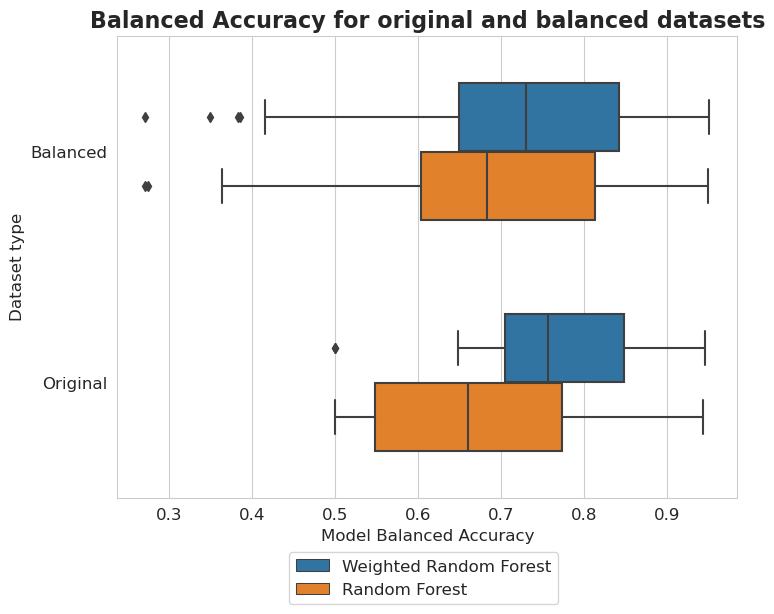

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=tmp['Dataset type'], x=tmp['Model Balanced Accuracy'], hue=tmp['Model'], width=0.6, whis=1.24)
plt.legend(bbox_to_anchor=(0.725, -0.1), fontsize=12)
plt.title('Balanced Accuracy for original and balanced datasets', fontsize=16, weight='bold')
plt.xlabel('Model Balanced Accuracy', fontsize=12)
plt.ylabel('Dataset type', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### Balancing methods

In [8]:
methods = [
    'UNDERSAMPLING__Random',
    'UNDERSAMPLING__Near_Miss',
    'OVERSAMPLING__Random',
    'OVERSAMPLING__SMOTE',
    'OVERSAMPLING__Borderline_SMOTE',
    'COMBINED__SMOTE_Tomek'
]

In [9]:
names = [
    'Random Undersampling',
    'Near Miss (undersampling)', 
    'Random Oversampling', 
    'SMOTE (oversampling)', 
    'Borderline SMOTE (oversampling)', 
    'SMOTETomek (hybrid)'
]

In [10]:
tmp_results_weighted = []
tmp_results_unweighted = []

for i in range(len(methods)):
    tmp = eval_weighted[eval_weighted.apply(lambda x: methods[i] in x['model'], axis=1)].copy()
    tmp['Model'] = 'Weighted Random Forest'
    tmp['Method'] = methods[i]
    tmp_results_weighted.append(tmp)
    
    tmp = eval_unweighted[eval_unweighted.apply(lambda x: methods[i] in x['model'], axis=1)].copy()
    tmp['Model'] = 'Random Forest'
    tmp['Method'] = methods[i]
    tmp_results_unweighted.append(tmp)

In [11]:
tmp1 = pd.concat(tmp_results_weighted)
tmp2 = pd.concat(tmp_results_unweighted)
tmp = pd.concat([tmp1, tmp2])

In [12]:
tmp.columns = ['model', 'metric', 'Model Balanced Accuracy', 'Model', 'Method']

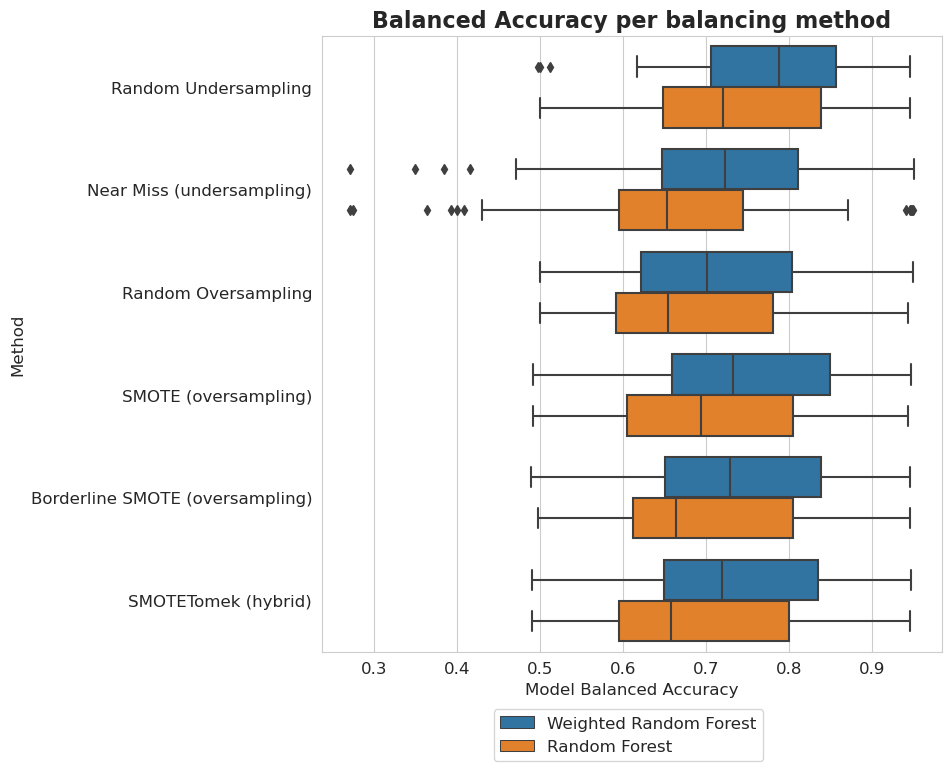

In [13]:
plt.figure(figsize=(8, 8))
ax = sns.boxplot(y=tmp['Method'], x=tmp['Model Balanced Accuracy'], hue=tmp['Model'], whis=1.25)
plt.title('Balanced Accuracy for balancing methods')
plt.yticks(np.arange(len(names)), names)
plt.legend(bbox_to_anchor=(0.725, -0.08), fontsize=12)
plt.title('Balanced Accuracy per balancing method', fontsize=16, weight='bold')
plt.xlabel('Model Balanced Accuracy', fontsize=12)
plt.ylabel('Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### Unbalancedness

In [14]:
balancedness = ['=0.8IR_RANGE', '=0.6IR_RANGE', '=0.4IR_RANGE', '=0.2IR_RANGE', '=0.0IR_RANGE']
vals = ['0.8', '0.6', '0.4', '0.2', '0.0']

In [15]:
tmp_results_weighted = []
tmp_results_unweighted = []

for i in range(len(balancedness)):
    tmp = eval_weighted[eval_weighted.apply(lambda x: balancedness[i] in x['model'], axis=1)].copy()
    tmp['Model'] = 'Weighted Random Forest'
    tmp['Balancedness'] = vals[i]
    tmp_results_weighted.append(tmp)
    
    tmp = eval_unweighted[eval_unweighted.apply(lambda x: balancedness[i] in x['model'], axis=1)].copy()
    tmp['Model'] = 'Random Forest'
    tmp['Balancedness'] = vals[i]
    tmp_results_unweighted.append(tmp)

In [16]:
tmp1 = pd.concat(tmp_results_weighted)
tmp2 = pd.concat(tmp_results_unweighted)
tmp = pd.concat([tmp1, tmp2])

tmp.columns = ['model', 'metric', 'Model Balanced Accuracy', 'Model', 'Unbalancedness']

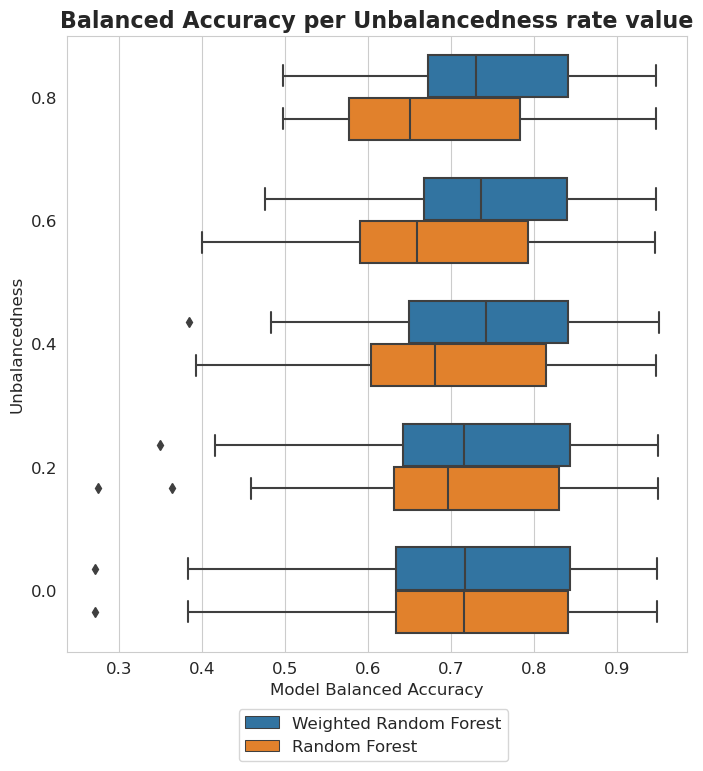

In [17]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=tmp['Unbalancedness'], x=tmp['Model Balanced Accuracy'], hue=tmp['Model'], width=0.7, whis=1.25)
plt.legend(bbox_to_anchor=(0.725, -0.08), fontsize=12)
plt.title('Balanced Accuracy per Unbalancedness rate value', fontsize=16, weight='bold')
plt.xlabel('Model Balanced Accuracy', fontsize=12)
plt.ylabel('Unbalancedness', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### `wilt` dataset - Unbalancedness

In [18]:
tmp_results_weighted = []
tmp_results_unweighted = []

for i in range(len(balancedness)):
    tmp = eval_weighted[eval_weighted.model.str.startswith('wilt')]
    tmp = tmp[tmp.apply(lambda x: balancedness[i] in x['model'], axis=1)].copy()
    tmp['Model'] = 'Weighted Random Forest'
    tmp['Balancedness'] = vals[i]
    tmp_results_weighted.append(tmp)
    
    tmp = eval_unweighted[eval_unweighted.model.str.startswith('wilt')]
    tmp = tmp[tmp.apply(lambda x: balancedness[i] in x['model'], axis=1)].copy()
    tmp['Model'] = 'Random Forest'
    tmp['Balancedness'] = vals[i]
    tmp_results_unweighted.append(tmp)

In [19]:
tmp1 = pd.concat(tmp_results_weighted)
tmp2 = pd.concat(tmp_results_unweighted)
tmp = pd.concat([tmp1, tmp2])

tmp.columns = ['model', 'metric', 'Model Balanced Accuracy', 'Model', 'Unbalancedness']

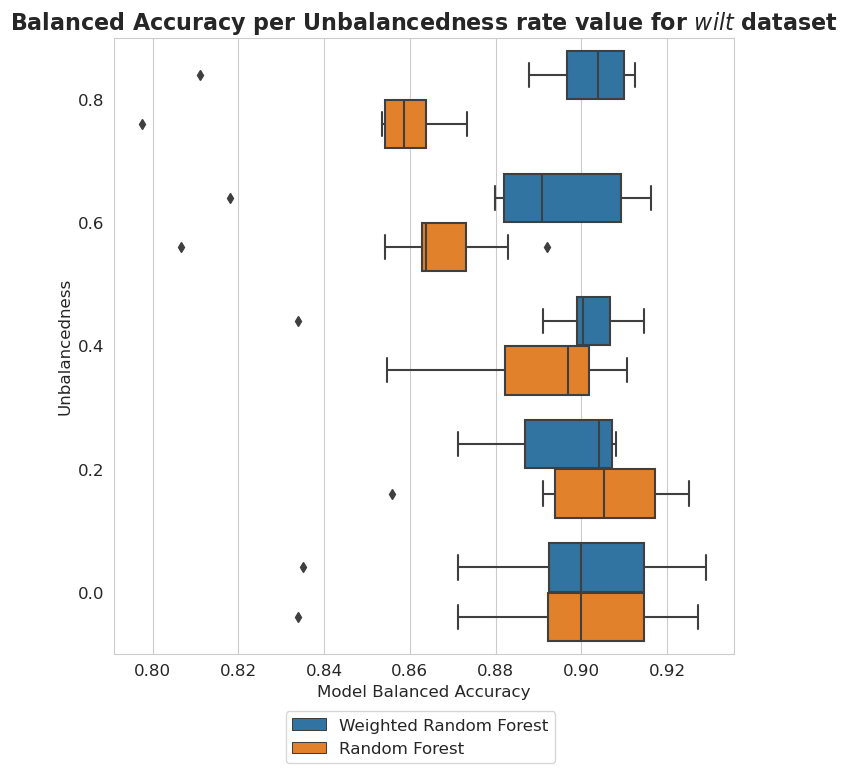

In [20]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=tmp['Unbalancedness'], x=tmp['Model Balanced Accuracy'], hue=tmp['Model'])
plt.legend(bbox_to_anchor=(0.725, -0.08), fontsize=12)
plt.title('Balanced Accuracy per Unbalancedness rate value for $\it{wilt}$ dataset', fontsize=16, weight='bold')
plt.xlabel('Model Balanced Accuracy', fontsize=12)
plt.ylabel('Unbalancedness', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Partial Dependence Profile

In [21]:
methods = [
    'UNDERSAMPLING__Random',
    'UNDERSAMPLING__Near_Miss',
    'OVERSAMPLING__Random',
    'OVERSAMPLING__SMOTE',
    'OVERSAMPLING__Borderline_SMOTE',
    'COMBINED__SMOTE_Tomek'
]

In [22]:
names = [
    'Random Undersampling',
    'Near Miss (undersampling)', 
    'Random Oversampling', 
    'SMOTE (oversampling)', 
    'Borderline SMOTE (oversampling)', 
    'SMOTETomek (hybrid)'
]

#### Methods

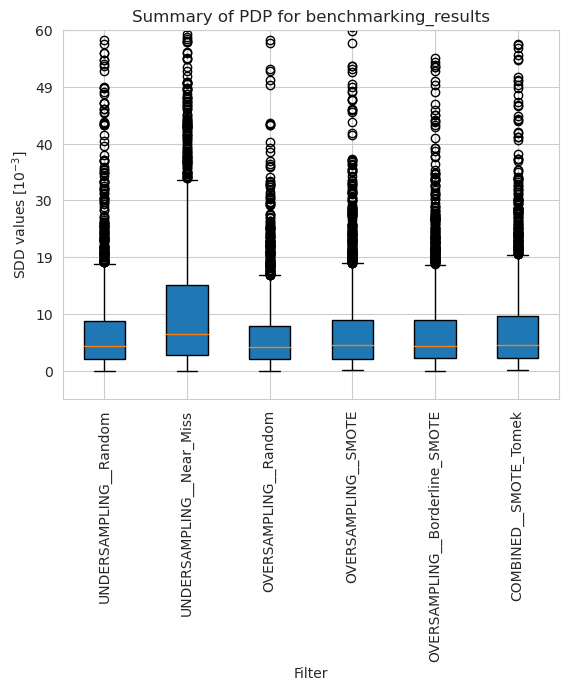

In [23]:
pdp_merged_unweighted_summary_results = pdp_unweighted.plot_summary(model_filters=methods, return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 60*10**(-3))
plt.show()

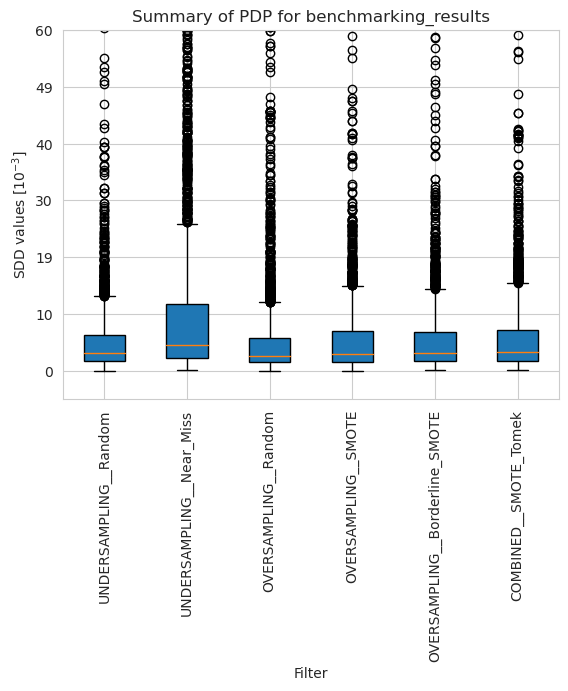

In [24]:
pdp_merged_weighted_summary_results = pdp_weighted.plot_summary(model_filters=methods, return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 60*10**(-3))
plt.show()

In [25]:
tmp = pd.DataFrame({'Method': [], 'Model': [], 'SDD values [$10^{-3}$]': []})

for i in range(len(names)):
    n = len(pdp_merged_weighted_summary_results[i])
    tmp2 = pd.DataFrame({
        'Method': [names[i] for _ in range(n)], 
        'Model': ['Weighted Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': pdp_merged_weighted_summary_results[i]})
    n = len(pdp_merged_unweighted_summary_results[i])
    tmp1 = pd.DataFrame({
        'Method': [names[i] for _ in range(n)], 
        'Model': ['Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': pdp_merged_unweighted_summary_results[i]})
    tmp = pd.concat([tmp, tmp2, tmp1])

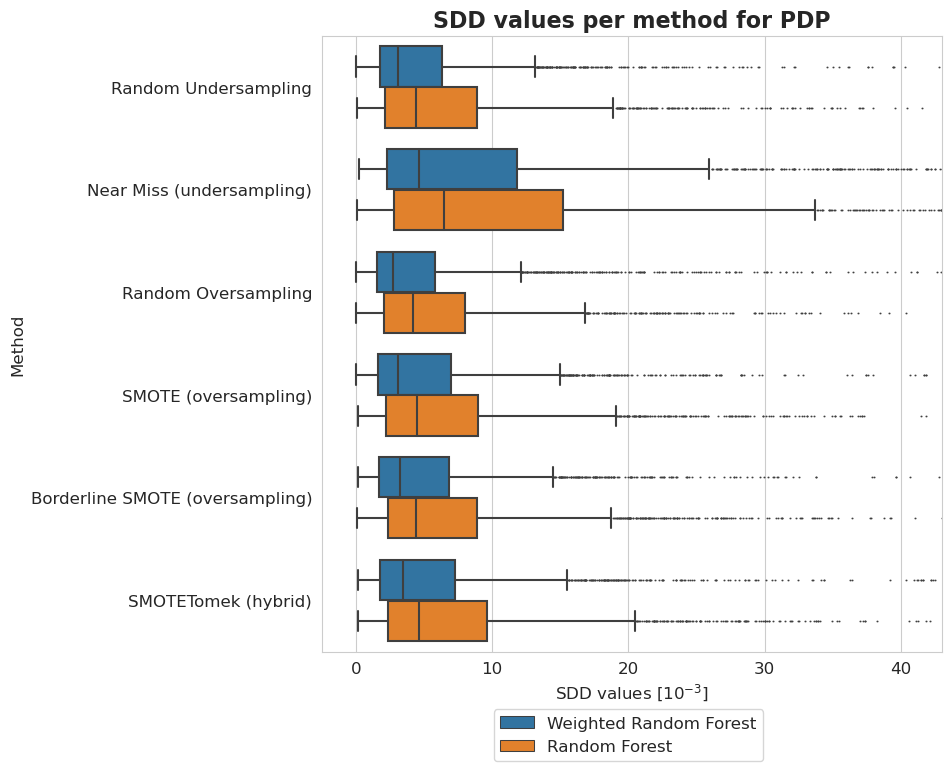

In [26]:
plt.figure(figsize=(8, 8))
ax = sns.boxplot(y = 'Method', x = 'SDD values [$10^{-3}$]', hue='Model', data=tmp, fliersize=0.5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: str(int(value * 10 ** 3))))
plt.xlim(-2.5*10**(-3), 43*10**(-3))
plt.xticks(np.arange(0, 50, 10)*10**(-3))
plt.legend(bbox_to_anchor=(0.725, -0.08), fontsize=12)
plt.title('SDD values per method for PDP', fontsize=16, weight='bold')
plt.xlabel('SDD values [$10^{-3}$]', fontsize=12)
plt.ylabel('Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### Datasets

In [27]:
dataset_names = [w.name.removesuffix('_automatic_transformed_array') for w in pdp_unweighted.results]
dataset_names.sort(key=lambda x: x.lower())

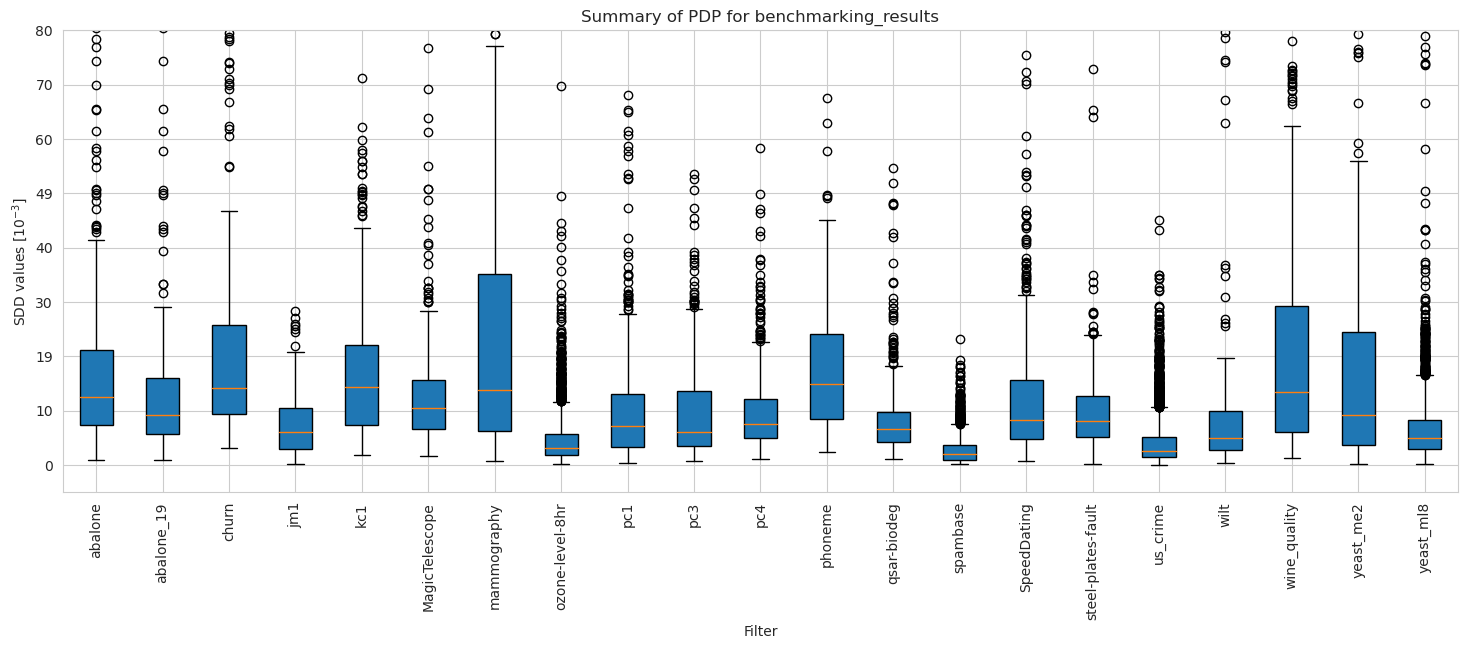

In [28]:
pdp_merged_unweighted_dataset_summary_results = pdp_unweighted.plot_summary(model_filters=dataset_names, figsize=(18, 6), return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 80*10**(-3))
plt.show()

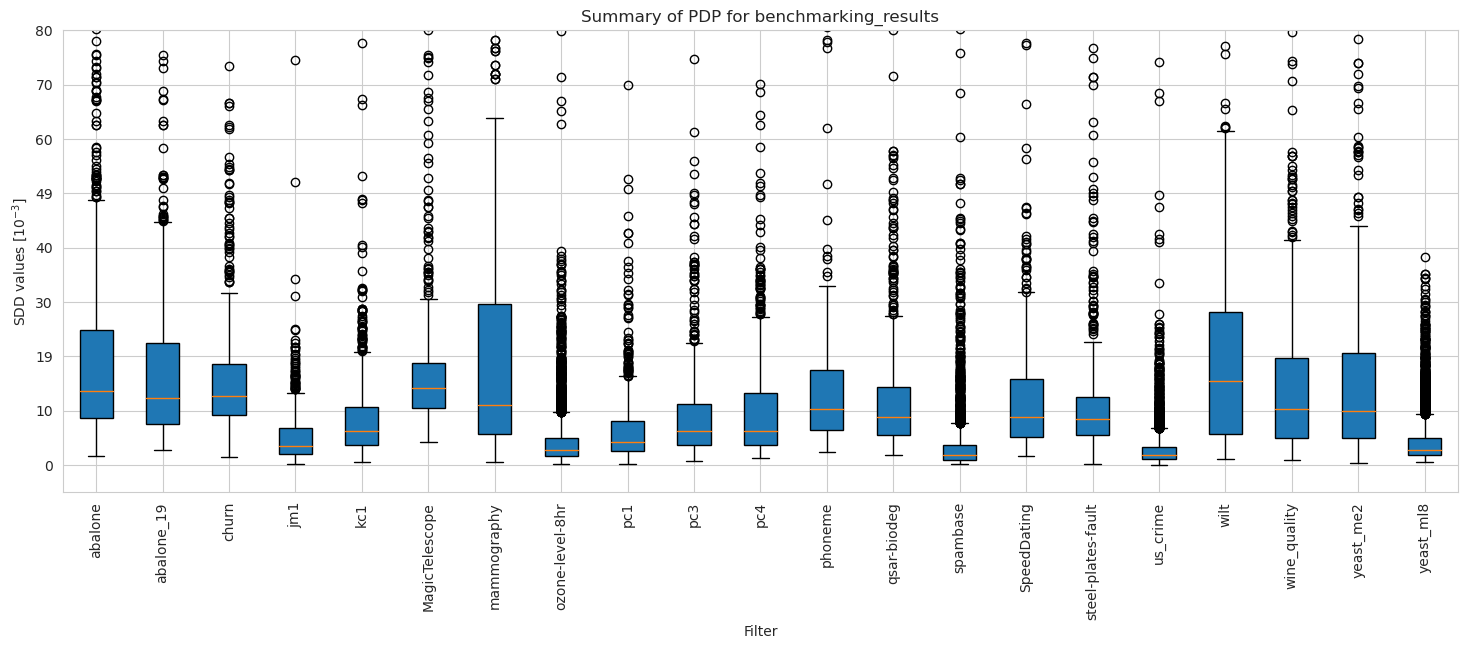

In [29]:
pdp_merged_weighted_dataset_summary_results = pdp_merged_weighted.plot_summary(model_filters=dataset_names, figsize=(18, 6), return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 80*10**(-3))
plt.show()

In [30]:
tmp = pd.DataFrame({'Dataset': [], 'Model': [], 'SDD values [$10^{-3}$]': []})

for i in range(len(dataset_names)):
    n = len(pdp_merged_weighted_dataset_summary_results[i])
    tmp2 = pd.DataFrame({
        'Dataset': [dataset_names[i] for _ in range(n)], 
        'Model': ['Weighted Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': pdp_merged_weighted_dataset_summary_results[i]})
    tmp = pd.concat([tmp, tmp2])

    n = len(pdp_merged_unweighted_dataset_summary_results[i])
    tmp1 = pd.DataFrame({
        'Dataset': [dataset_names[i] for _ in range(n)], 
        'Model': ['Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': pdp_merged_unweighted_dataset_summary_results[i]})
    tmp = pd.concat([tmp, tmp1])

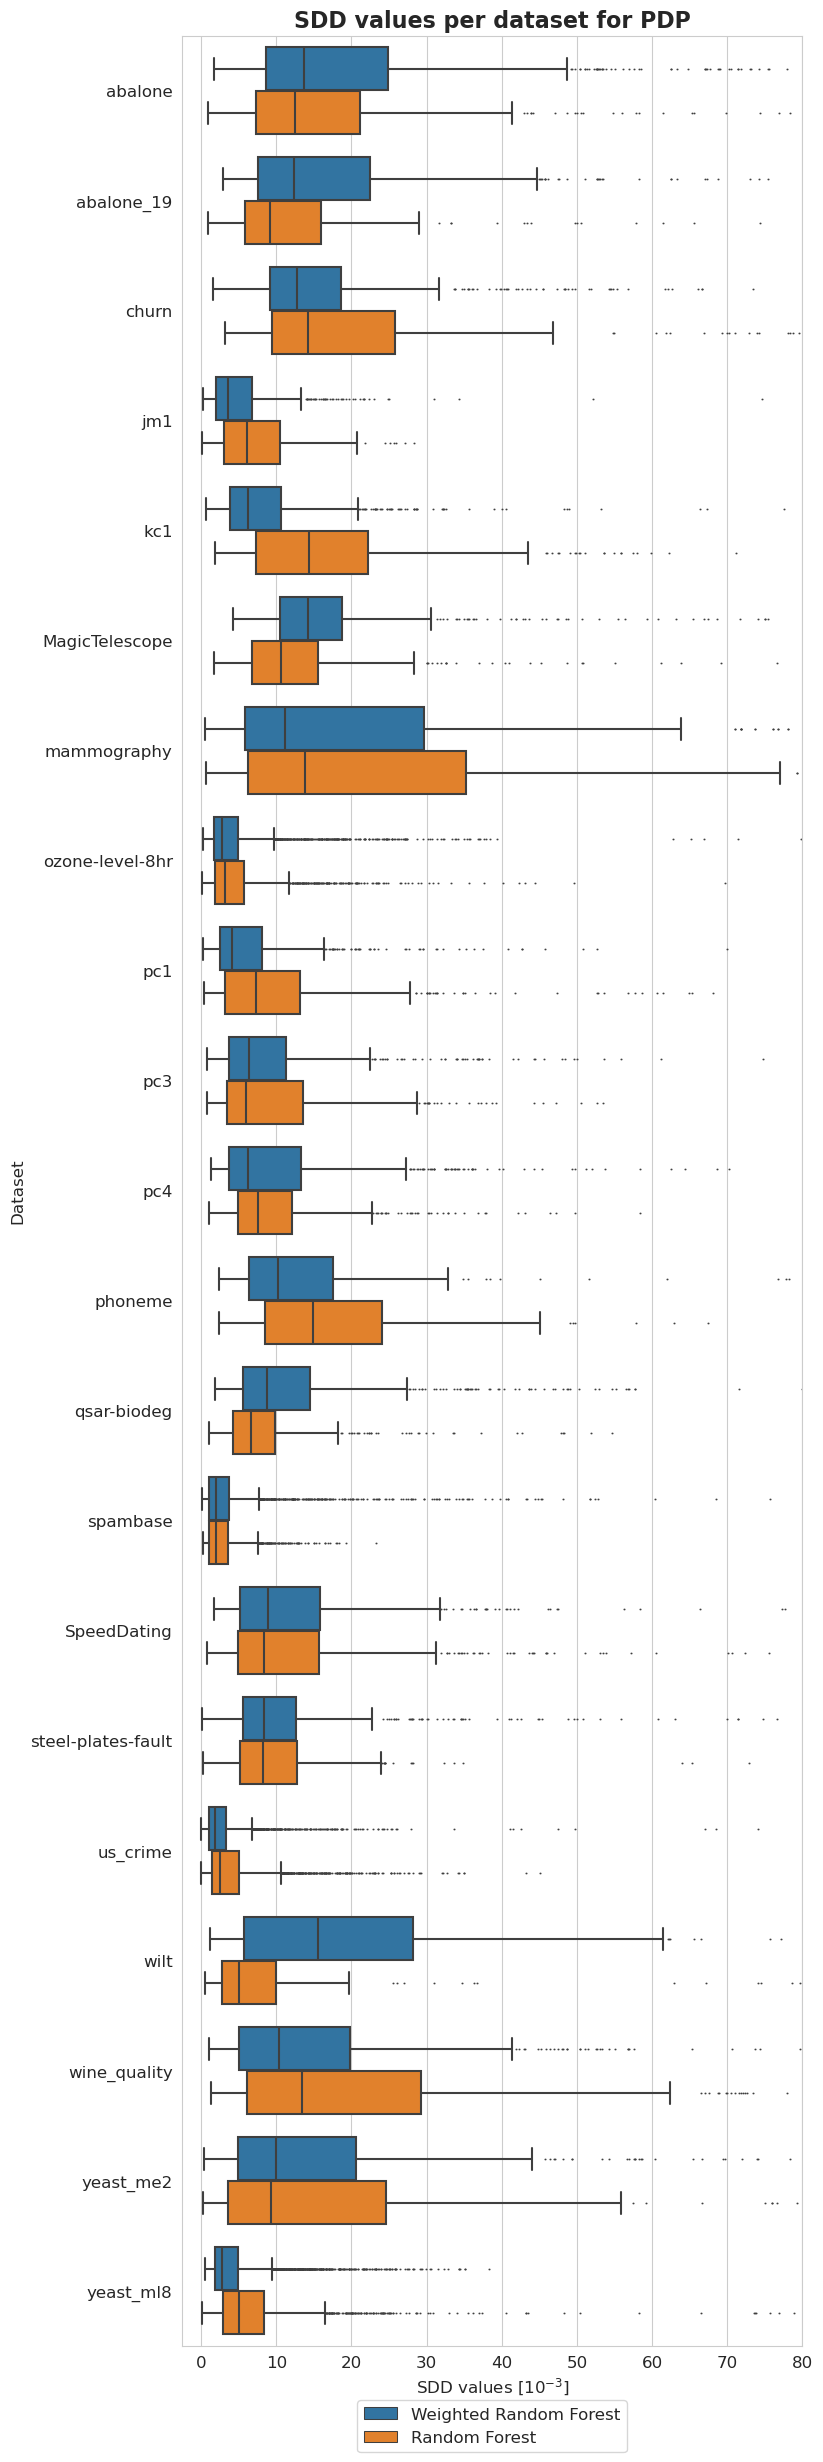

In [31]:
plt.figure(figsize=(8, 30))
ax = sns.boxplot(y = 'Dataset', x = 'SDD values [$10^{-3}$]', hue='Model', data=tmp, fliersize=0.5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: str(int(value * 10 ** 3))))
plt.xlim(-2.5*10**(-3), 80*10**(-3))
plt.xticks(np.arange(0, 90, 10)*10**(-3))
plt.legend(bbox_to_anchor=(0.73, -0.02), fontsize=12)
plt.title('SDD values per dataset for PDP', fontsize=16, weight='bold')
plt.xlabel('SDD values [$10^{-3}$]', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### Balancedness

In [32]:
balancedness = ['=0.8IR_RANGE', '=0.6IR_RANGE', '=0.4IR_RANGE', '=0.2IR_RANGE', '=0.0IR_RANGE']
vals = ['0.8', '0.6', '0.4', '0.2', '0.0']

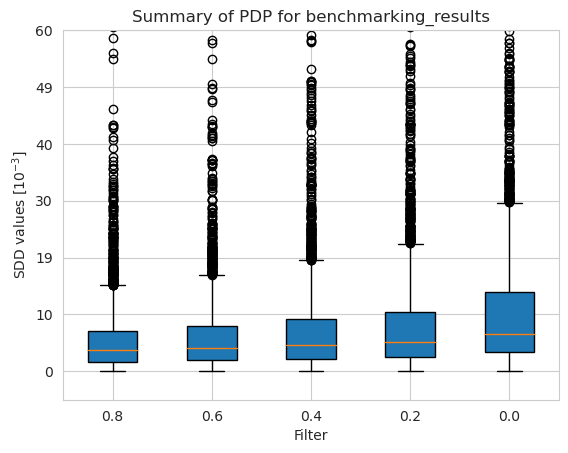

In [37]:
pdp_merged_unweighted_unbalancedness_summary_results = pdp_unweighted.plot_summary(balancedness, vals, return_df=True)
plt.ylim(-5*10**(-3), 60*10**(-3))
plt.show()

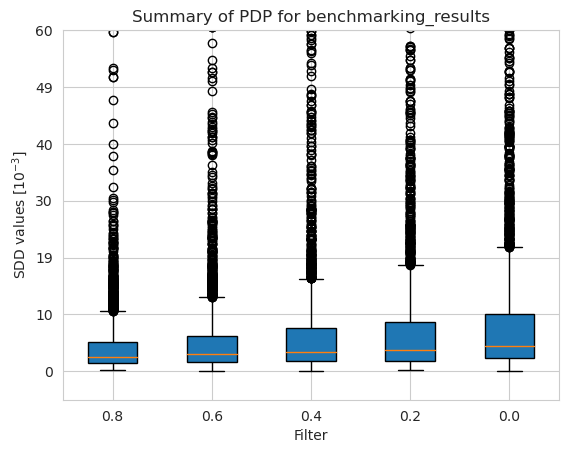

In [38]:
pdp_merged_weighted_unbalancedness_summary_results = pdp_weighted.plot_summary(balancedness, vals, return_df=True)
plt.ylim(-5*10**(-3), 60*10**(-3))
plt.show()

In [40]:
tmp = pd.DataFrame({'Unbalancedness': [], 'Model': [], 'SDD values [$10^{-3}$]': []})

for i in range(len(balancedness)):
    n = len(pdp_merged_unweighted_unbalancedness_summary_results[i])
    tmp2 = pd.DataFrame({
        'Unbalancedness': [vals[i] for _ in range(n)], 
        'Model': ['Weighted Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': pdp_merged_unweighted_unbalancedness_summary_results[i]})
    tmp = pd.concat([tmp, tmp2])

    n = len(pdp_merged_unweighted_unbalancedness_summary_results[i])
    tmp1 = pd.DataFrame({
        'Unbalancedness': [vals[i] for _ in range(n)], 
        'Model': ['Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': pdp_merged_unweighted_unbalancedness_summary_results[i]})
    tmp = pd.concat([tmp, tmp1])

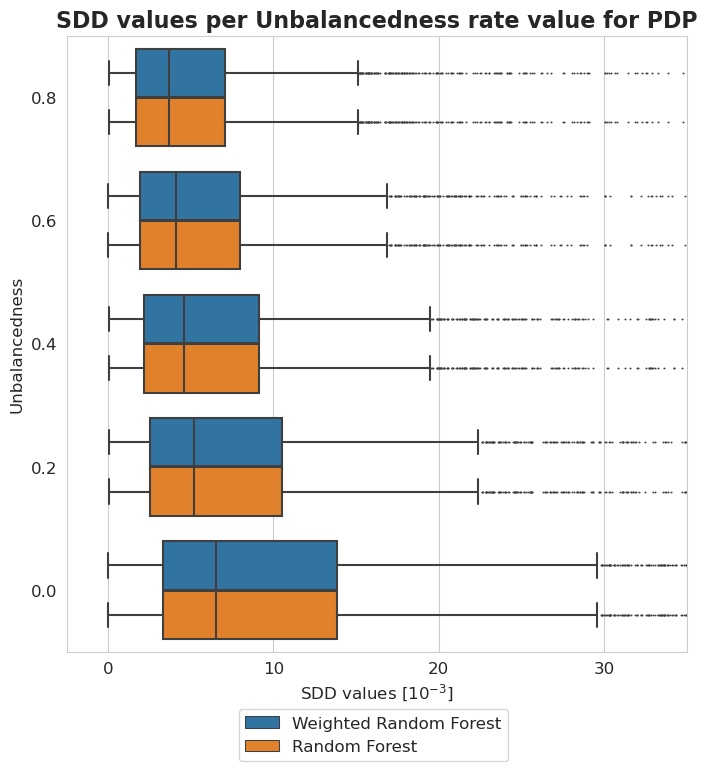

In [41]:
plt.figure(figsize=(8, 8))
ax = sns.boxplot(y = 'Unbalancedness', x = 'SDD values [$10^{-3}$]', hue='Model', data=tmp, fliersize=0.5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: str(int(value * 10 ** 3))))
plt.xlim(-2.5*10**(-3), 35*10**(-3))
plt.xticks(np.arange(0, 40, 10)*10**(-3))
plt.legend(bbox_to_anchor=(0.725, -0.08), fontsize=12)
plt.title('SDD values per Unbalancedness rate value for PDP', fontsize=16, weight='bold')
plt.xlabel('SDD values [$10^{-3}$]', fontsize=12)
plt.ylabel('Unbalancedness', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Accumulated Local Effects

In [42]:
methods = [
    'UNDERSAMPLING__Random',
    'UNDERSAMPLING__Near_Miss',
    'OVERSAMPLING__Random',
    'OVERSAMPLING__SMOTE',
    'OVERSAMPLING__Borderline_SMOTE',
    'COMBINED__SMOTE_Tomek'
]

In [43]:
names = [
    'Random Undersampling',
    'Near Miss (undersampling)', 
    'Random Oversampling', 
    'SMOTE (oversampling)', 
    'Borderline SMOTE (oversampling)', 
    'SMOTETomek (hybrid)'
]

#### Methods

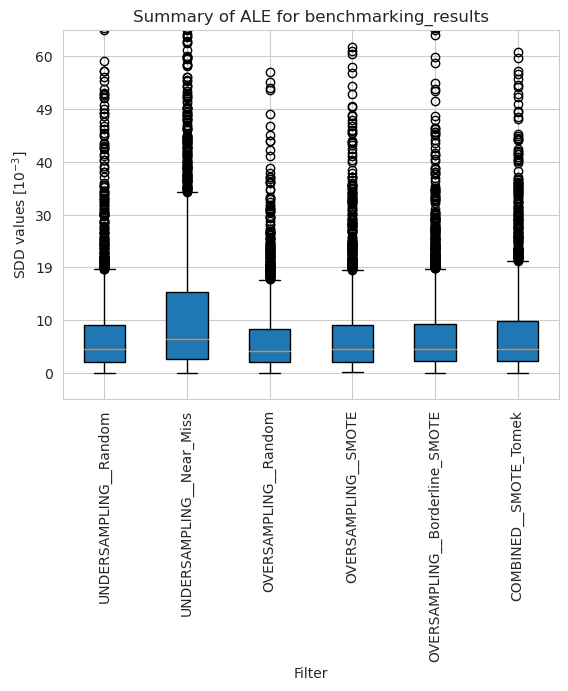

In [44]:
ale_merged_unweighted_summary_results = ale_unweighted.plot_summary(model_filters=methods, return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 65*10**(-3))
plt.show()

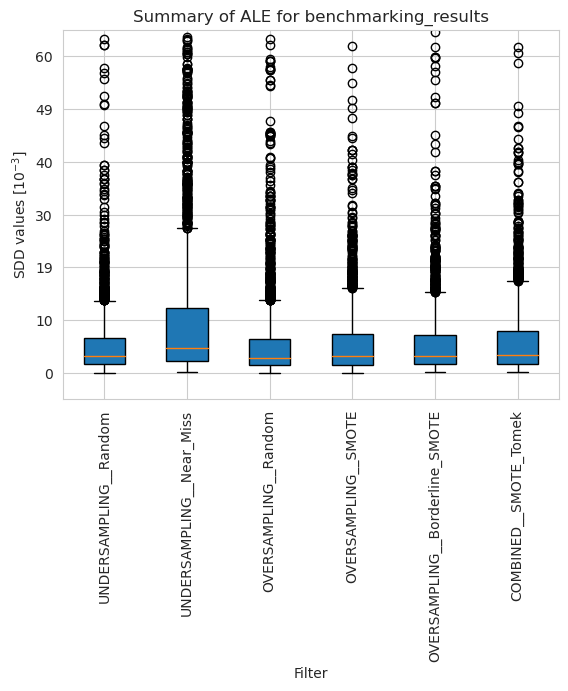

In [45]:
ale_merged_weighted_summary_results = ale_weighted.plot_summary(model_filters=methods, return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 65*10**(-3))
plt.show()

In [46]:
tmp = pd.DataFrame({'Method': [], 'Model': [], 'SDD values [$10^{-3}$]': []})

for i in range(len(names)):
    n = len(ale_merged_weighted_summary_results[i])
    tmp2 = pd.DataFrame({
        'Method': [names[i] for _ in range(n)], 
        'Model': ['Weighted Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': ale_merged_weighted_summary_results[i]})
    
    n = len(ale_merged_unweighted_summary_results[i])
    tmp1 = pd.DataFrame({
        'Method': [names[i] for _ in range(n)], 
        'Model': ['Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': ale_merged_unweighted_summary_results[i]})
    tmp = pd.concat([tmp, tmp2, tmp1])

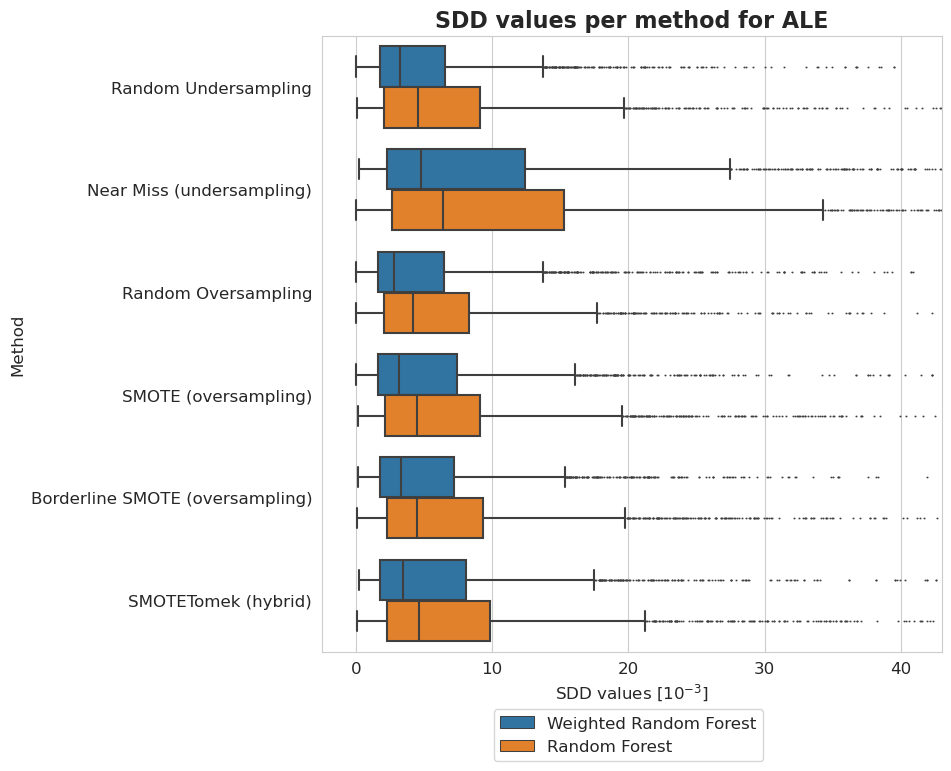

In [47]:
plt.figure(figsize=(8, 8))
ax = sns.boxplot(y = 'Method', x = 'SDD values [$10^{-3}$]', hue='Model', data=tmp, fliersize=0.5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: str(int(value * 10 ** 3))))
plt.xlim(-2.5*10**(-3), 43*10**(-3))
plt.xticks(np.arange(0, 50, 10)*10**(-3))
plt.legend(bbox_to_anchor=(0.725, -0.08), fontsize=12)
plt.title('SDD values per method for ALE', fontsize=16, weight='bold')
plt.xlabel('SDD values [$10^{-3}$]', fontsize=12)
plt.ylabel('Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### Datasets

In [48]:
dataset_names = [w.name.removesuffix('_automatic_transformed_array') for w in ale_unweighted.results]
dataset_names.sort(key=lambda x: x.lower())

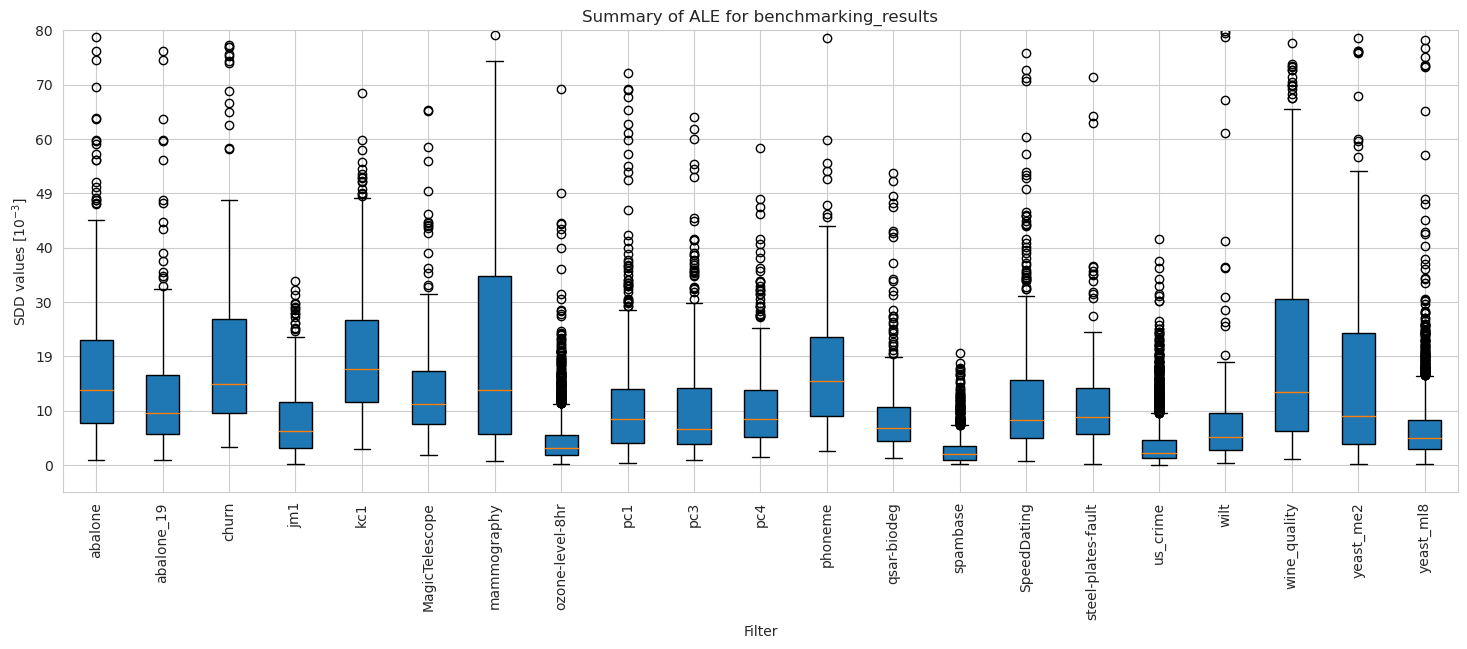

In [49]:
ale_merged_unweighted_dataset_summary_results = ale_unweighted.plot_summary(model_filters=dataset_names, figsize=(18, 6), return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 80*10**(-3))
plt.show()

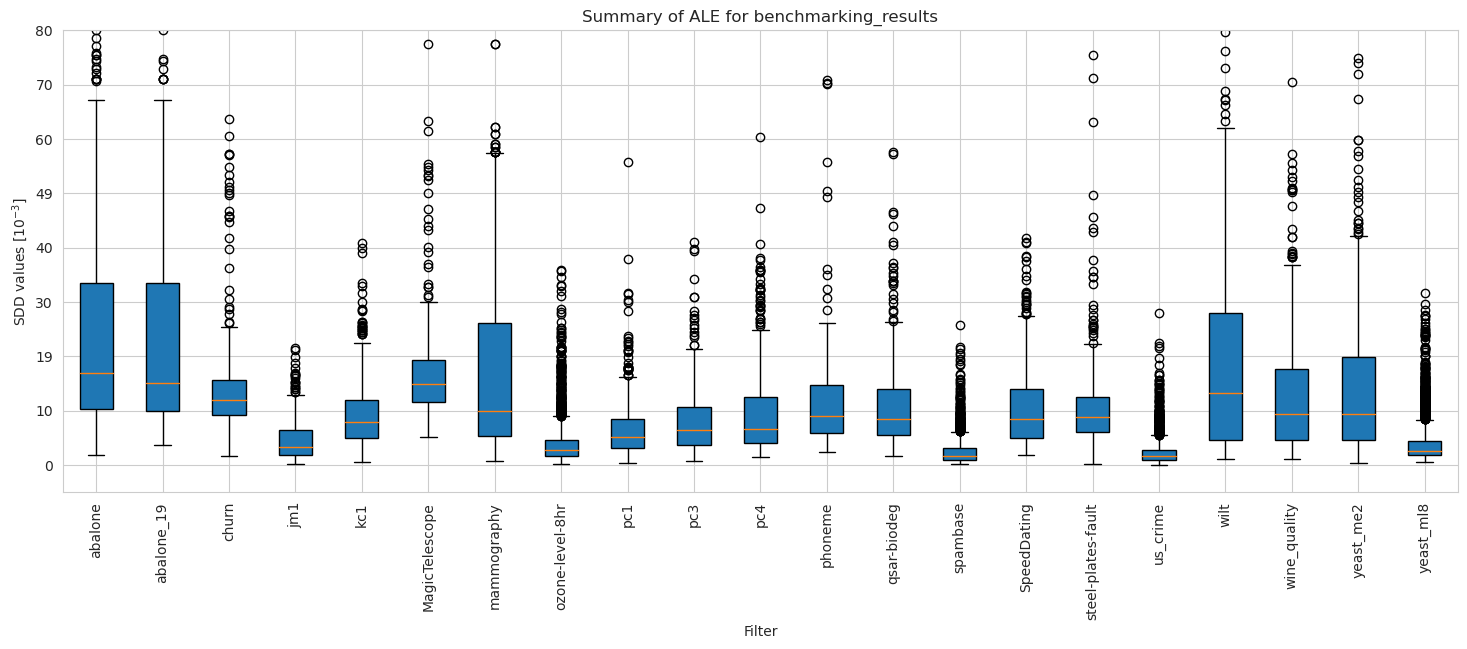

In [50]:
ale_merged_weighted_dataset_summary_results = ale_weighted.plot_summary(model_filters=dataset_names, figsize=(18, 6), return_df=True)
plt.xticks(rotation=90)
plt.ylim(-5*10**(-3), 80*10**(-3))
plt.show()

In [51]:
tmp = pd.DataFrame({'Dataset': [], 'Model': [], 'SDD values [$10^{-3}$]': []})

for i in range(len(dataset_names)):
    n = len(ale_merged_weighted_dataset_summary_results[i])
    tmp2 = pd.DataFrame({
        'Dataset': [dataset_names[i] for _ in range(n)], 
        'Model': ['Weighted Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': ale_merged_weighted_dataset_summary_results[i]})
    tmp = pd.concat([tmp, tmp2])

for i in range(len(dataset_names)):
    n = len(ale_merged_unweighted_dataset_summary_results[i])
    tmp1 = pd.DataFrame({
        'Dataset': [dataset_names[i] for _ in range(n)], 
        'Model': ['Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': ale_merged_unweighted_dataset_summary_results[i]})
    tmp = pd.concat([tmp, tmp1])

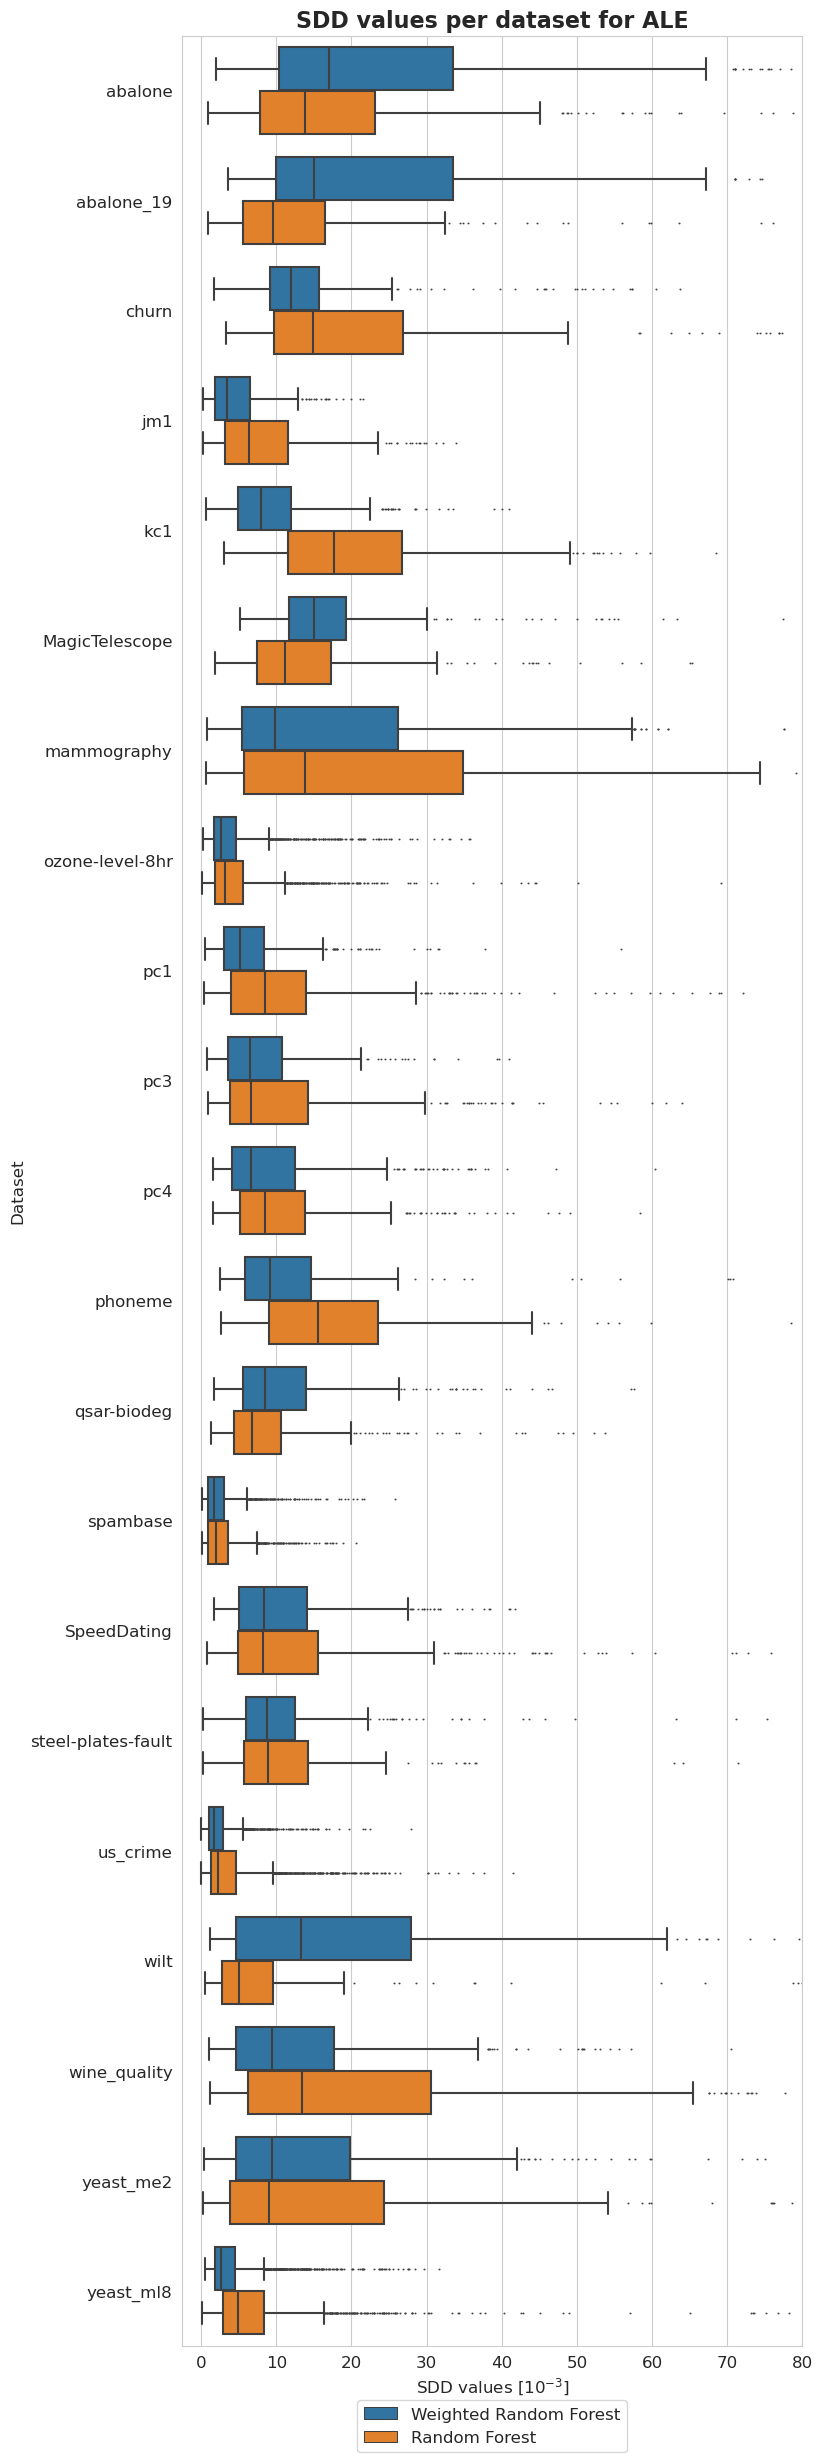

In [52]:
plt.figure(figsize=(8, 30))
ax = sns.boxplot(y = 'Dataset', x = 'SDD values [$10^{-3}$]', hue='Model', data=tmp, fliersize=0.5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: str(int(value * 10 ** 3))))
plt.xlim(-2.5*10**(-3), 80*10**(-3))
plt.xticks(np.arange(0, 90, 10)*10**(-3))
plt.legend(bbox_to_anchor=(0.73, -0.02), fontsize=12)
plt.title('SDD values per dataset for ALE', fontsize=16, weight='bold')
plt.xlabel('SDD values [$10^{-3}$]', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### Balancedness

In [53]:
balancedness = ['=0.8IR_RANGE', '=0.6IR_RANGE', '=0.4IR_RANGE', '=0.2IR_RANGE', '=0.0IR_RANGE']
vals = ['0.8', '0.6', '0.4', '0.2', '0.0']

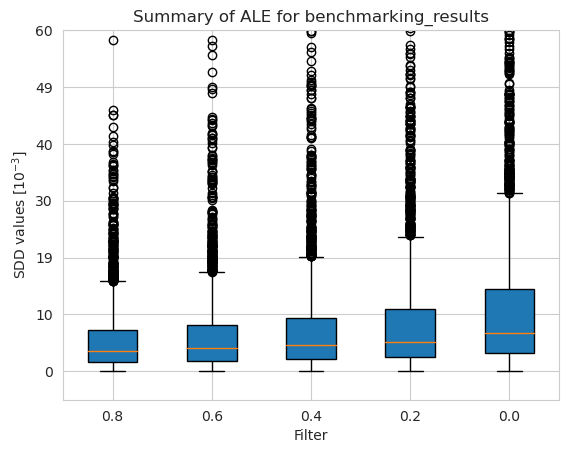

In [54]:
ale_merged_unweighted_unbalancedness_summary_results = ale_unweighted.plot_summary(balancedness, vals, return_df=True)
plt.ylim(-5*10**(-3), 60*10**(-3))
plt.show()

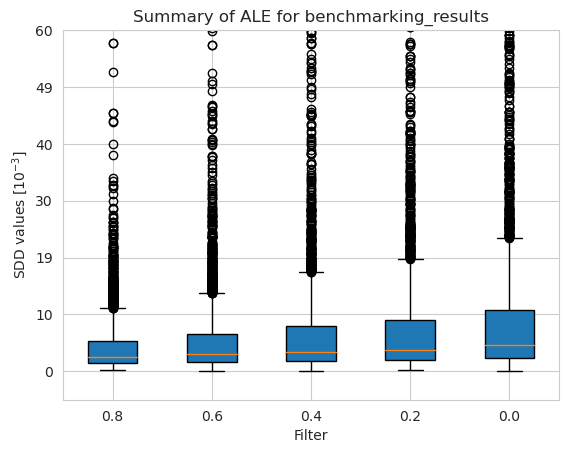

In [55]:
ale_merged_weighted_unbalancedness_summary_results = ale_weighted.plot_summary(balancedness, vals, return_df=True)
plt.ylim(-5*10**(-3), 60*10**(-3))
plt.show()

In [56]:
tmp = pd.DataFrame({'Unbalancedness': [], 'Model': [], 'SDD values [$10^{-3}$]': []})

for i in range(len(balancedness)):
    n = len(ale_merged_weighted_unbalancedness_summary_results[i])
    tmp2 = pd.DataFrame({
        'Unbalancedness': [vals[i] for _ in range(n)], 
        'Model': ['Weighted Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': ale_merged_weighted_unbalancedness_summary_results[i]})
    tmp = pd.concat([tmp, tmp2])

for i in range(len(balancedness)):
    n = len(ale_merged_unweighted_unbalancedness_summary_results[i])
    tmp1 = pd.DataFrame({
        'Unbalancedness': [vals[i] for _ in range(n)], 
        'Model': ['Random Forest' for _ in range(n)], 
        'SDD values [$10^{-3}$]': ale_merged_unweighted_unbalancedness_summary_results[i]})
    tmp = pd.concat([tmp, tmp1])

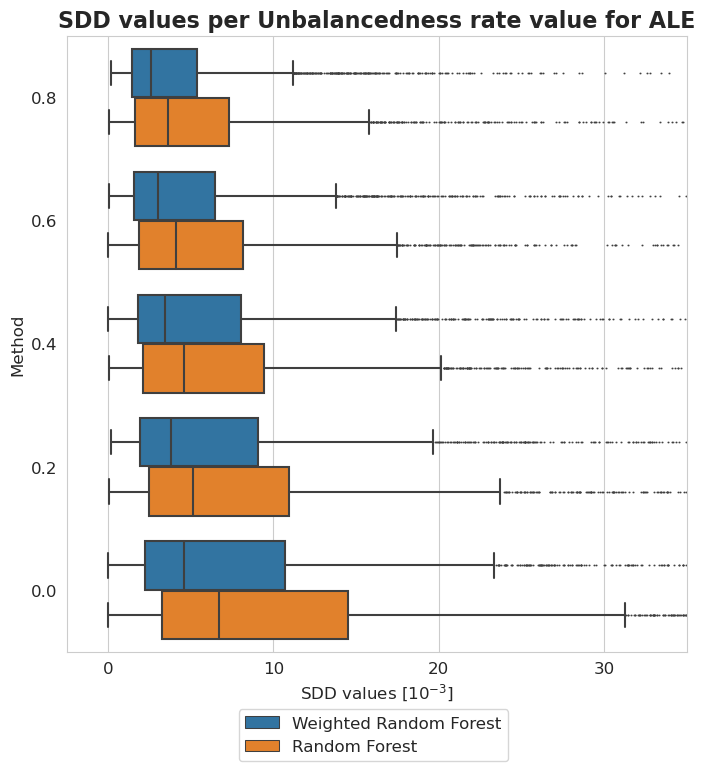

In [57]:
plt.figure(figsize=(8, 8))
ax = sns.boxplot(y = 'Unbalancedness', x = 'SDD values [$10^{-3}$]', hue='Model', data=tmp, fliersize=0.5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: str(int(value * 10 ** 3))))
plt.xlim(-2.5*10**(-3), 35*10**(-3))
plt.xticks(np.arange(0, 40, 10)*10**(-3))
plt.legend(bbox_to_anchor=(0.725, -0.08), fontsize=12)
plt.title('SDD values per Unbalancedness rate value for ALE', fontsize=16, weight='bold')
plt.xlabel('SDD values [$10^{-3}$]', fontsize=12)
plt.ylabel('Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### ALE plots for `Mean_NIR` in `wilt` dataset

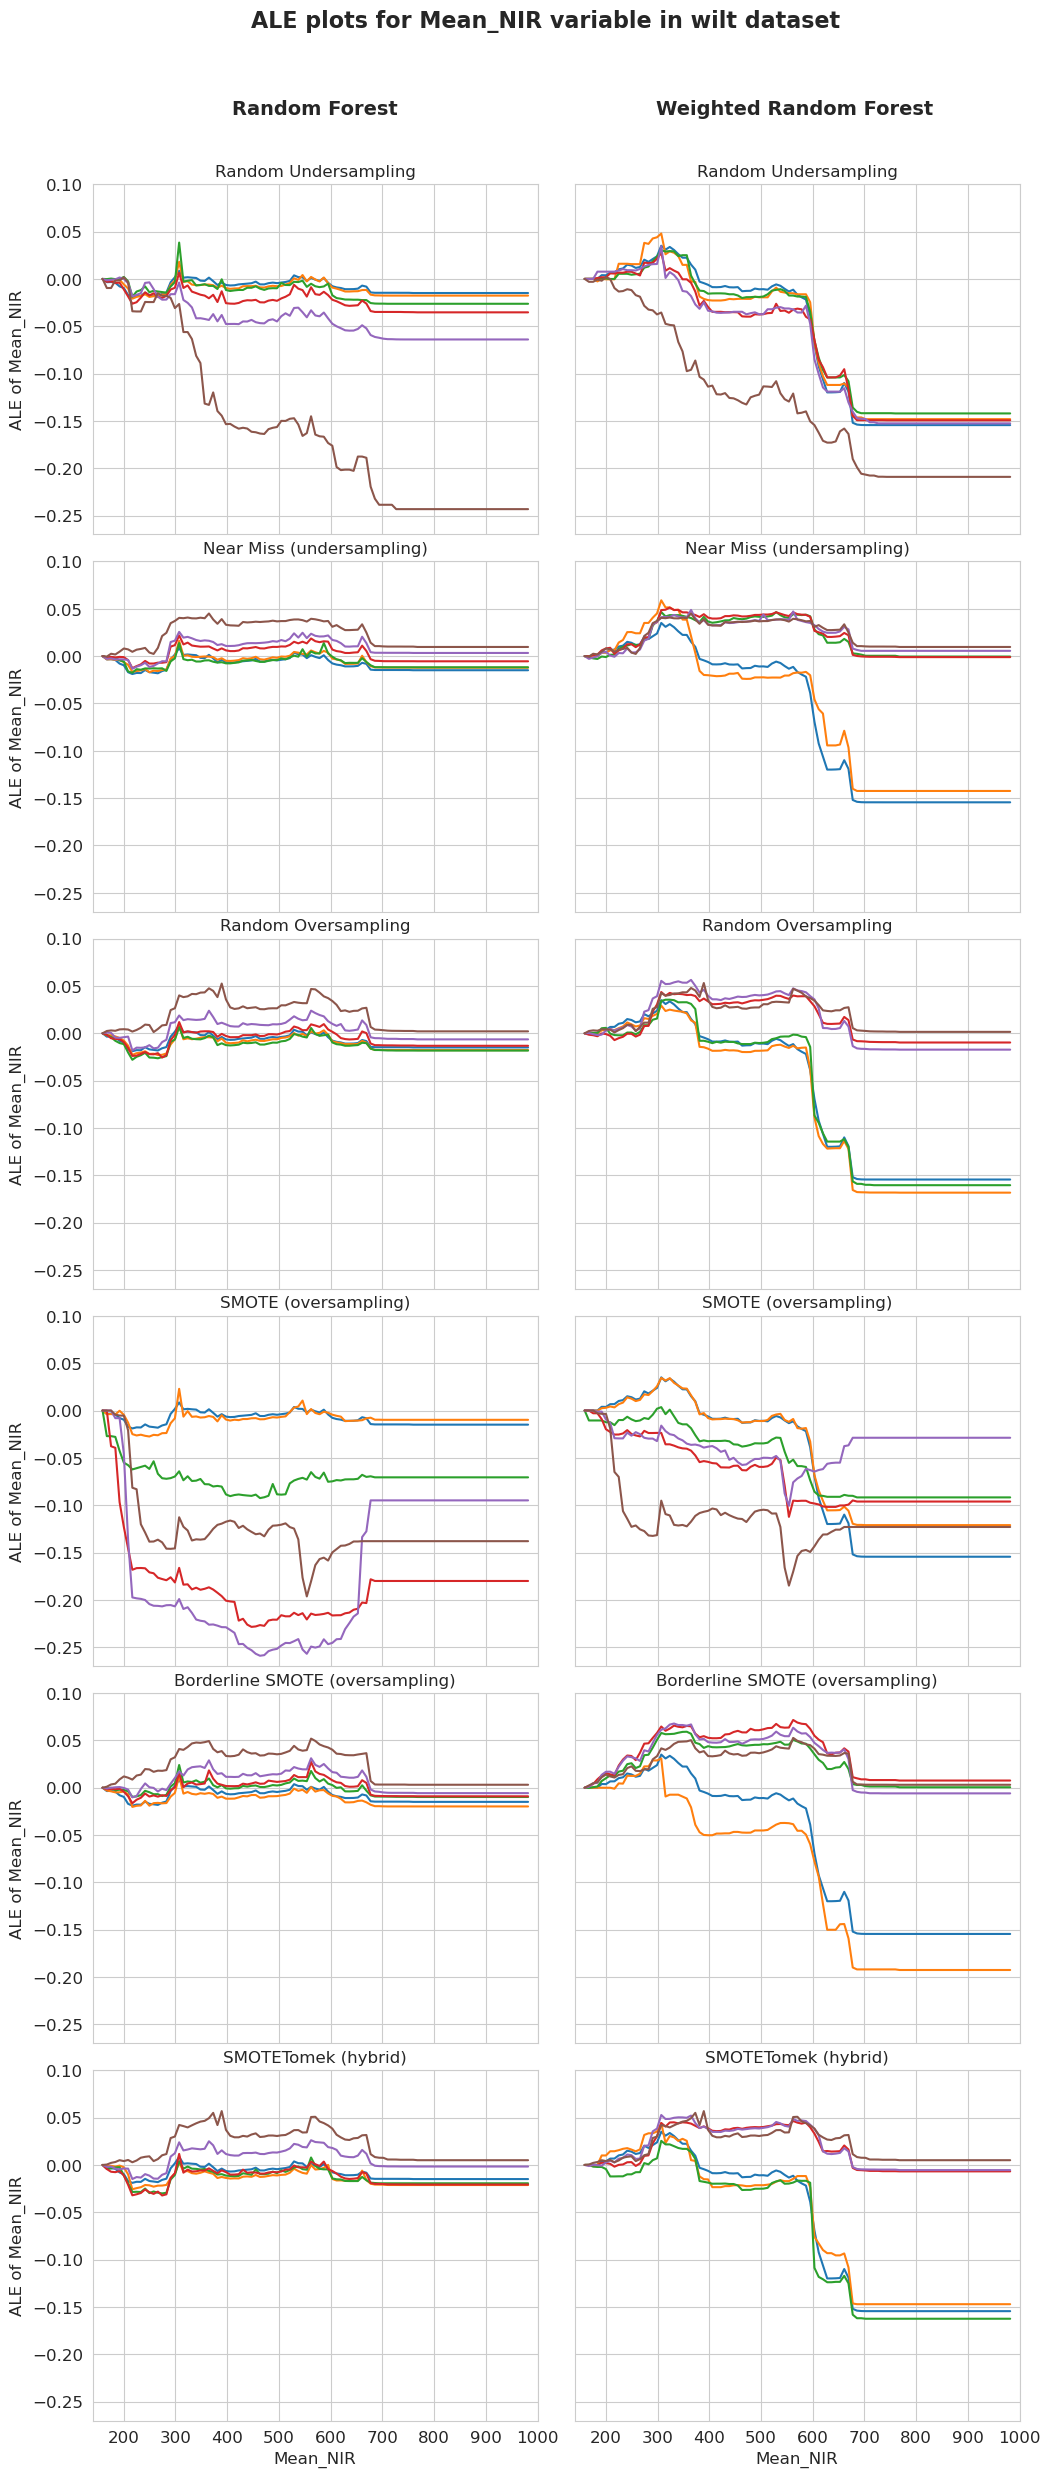

In [58]:
fig, ax = plt.subplots(6, 2, sharex=True, sharey='row', figsize=(10, 25))

tit = plt.suptitle('ALE plots for Mean_NIR variable in wilt dataset', fontsize=16, weight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.figtext(0.186, 0.938, 'Random Forest', fontsize=14, weight='bold')
plt.figtext(0.61, 0.938, 'Weighted Random Forest', fontsize=14, weight='bold')

for k in range((len(ale_unweighted[-4])-1)):
    ale_unweighted[-4][-1].plot(variable='Mean_NIR', ax=ax[k][0], add_plot=ale_unweighted[-4][k], show_legend=False, centered=True)
    ax[k][0].texts = []
    plt.xlim(140, 1000)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize=12)
    plt.title(names[k], fontsize=12)
    
for k in range((len(ale_weighted[-4])-1)):
    ale_weighted[-4][-1].plot(variable='Mean_NIR', ax=ax[k][1], add_plot=ale_weighted[-4][k], show_legend=False, centered=True)
    ax[k][1].texts = []
    plt.xlim(140, 1000)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(names[k], fontsize=12)

for k in range(len(names)):
    plt.sca(ax[k][0])
    plt.ylabel('ALE of Mean_NIR', fontsize=12)
    plt.ylim(-0.27, 0.1)
    
plt.sca(ax[-1][0])
plt.xlabel('Mean_NIR', fontsize=12)
plt.xticks(fontsize=12)

plt.sca(ax[-1][1])
plt.xlabel('Mean_NIR', fontsize=12)
plt.xticks(fontsize=12)

plt.show()

### Variable Importance

In [59]:
methods = [
    'UNDERSAMPLING__Random',
    'UNDERSAMPLING__Near_Miss',
    'OVERSAMPLING__Random',
    'OVERSAMPLING__SMOTE',
    'OVERSAMPLING__Borderline_SMOTE',
    'COMBINED__SMOTE_Tomek'
]

In [60]:
names = [
    'Random Undersampling',
    'Near Miss (undersampling)', 
    'Random Oversampling', 
    'SMOTE (oversampling)', 
    'Borderline SMOTE (oversampling)', 
    'SMOTETomek (hybrid)'
]

In [61]:
def extract_accepted_rejected(tab, significance_level):
    n = len(tab)
    res = np.array(tab)
    reject = np.sum(res <= significance_level)
    accept = n - reject
    return accept / n, reject / n

#### Methods

/home/adrian/anaconda3/envs/EDGAR/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


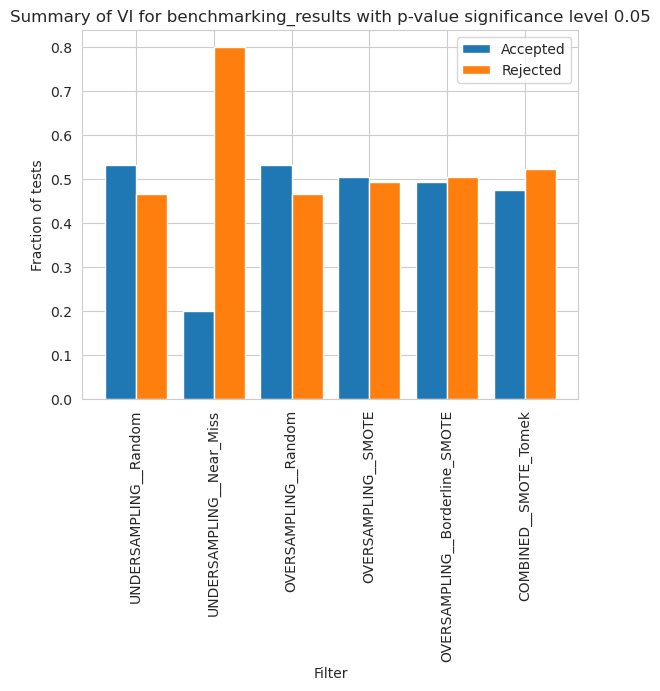

In [62]:
vi_merged_unweighted_summary_results = vi_unweighted.plot_summary(model_filters=methods, significance_level=0.05, return_df=True)
plt.xticks(rotation=90)
plt.show()

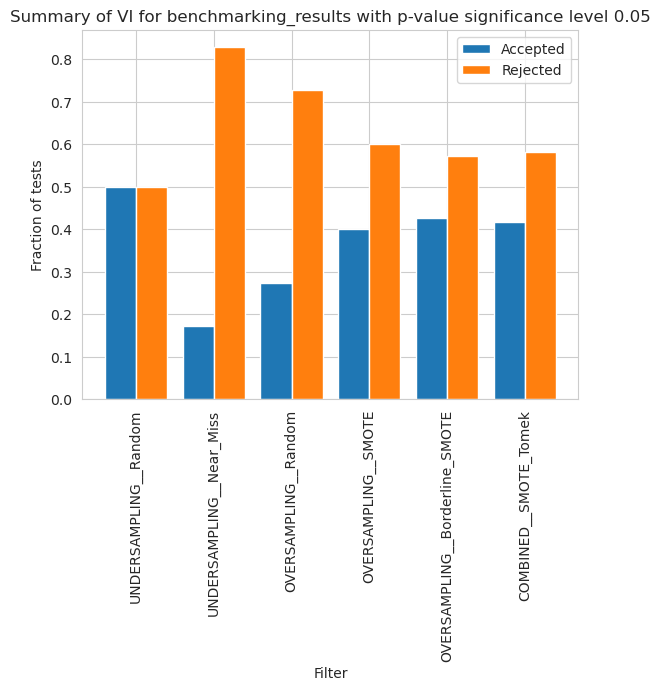

In [63]:
vi_merged_weighted_summary_results = vi_weighted.plot_summary(model_filters=methods, significance_level=0.05, return_df=True)
plt.xticks(rotation=90)
plt.show()

In [64]:
vi_merged_weighted_summary_results_accepted = [extract_accepted_rejected(q, 0.05) for q in vi_merged_weighted_summary_results]
vi_merged_unweighted_summary_results_accepted = [extract_accepted_rejected(q, 0.05) for q in vi_merged_unweighted_summary_results]

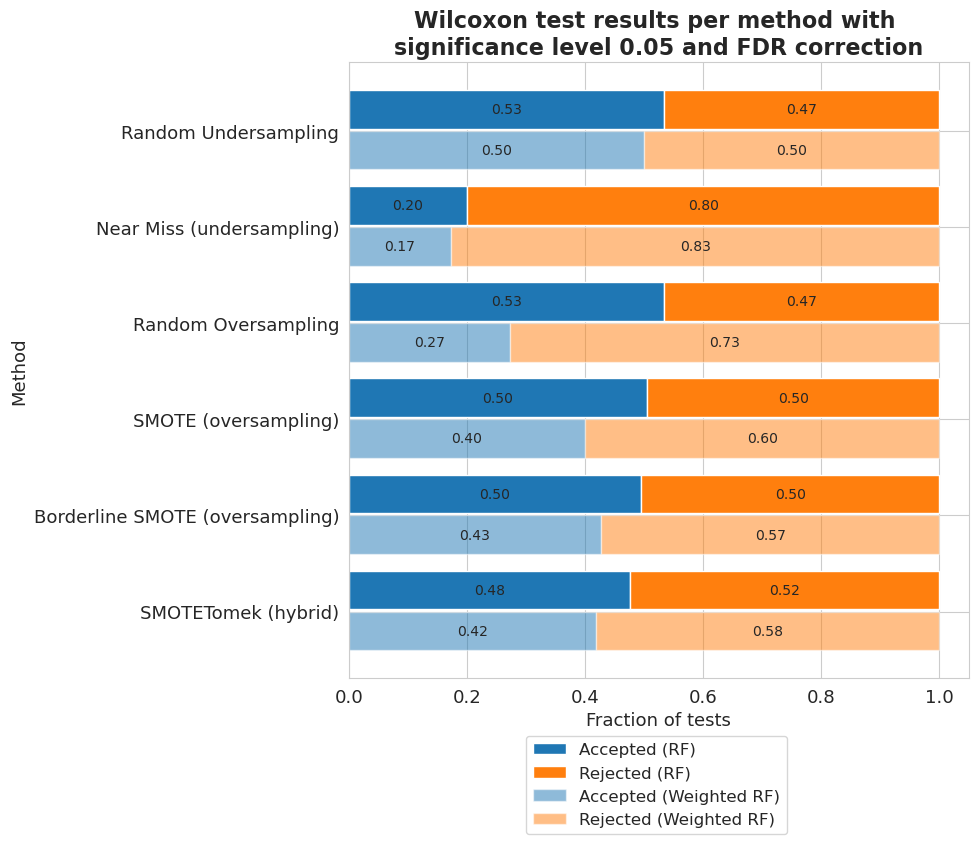

In [65]:
plt.figure(figsize=(8, 8))

height = 0.4

r = np.arange(len(methods)) - height/2 - 0.025
bottom = [q[0] for q in vi_merged_unweighted_summary_results_accepted]
top = [q[1] for q in vi_merged_unweighted_summary_results_accepted]
bar1 = plt.barh(r, bottom, height=height, label='Accepted (RF)', color='#1f77b4')
bar2 = plt.barh(r, top, left=bottom, height=height, label='Rejected (RF)', color='#ff7f0e')

r = r + height + 0.025
bottom = [q[0] for q in vi_merged_weighted_summary_results_accepted]
top = [q[1] for q in vi_merged_weighted_summary_results_accepted]
bar3 = plt.barh(r, bottom, height=height, label='Accepted (Weighted RF)', color='#1f77b4', alpha=0.5)
bar4 = plt.barh(r, top, left=bottom, height=height, label='Rejected (Weighted RF)', color='#ff7f0e', alpha=0.5)
plt.yticks(np.arange(len(methods)), names)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(0.72, -0.08), fontsize=12)
plt.title('Wilcoxon test results per method with \nsignificance level 0.05 and FDR correction', fontsize=16, weight='bold')
plt.xlabel('Fraction of tests', fontsize=13)
plt.ylabel('Method', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax = plt.gca()
ax.bar_label(bar1, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar1], label_type='center', fontsize=10)
ax.bar_label(bar2, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar2], label_type='center', fontsize=10)
ax.bar_label(bar3, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar3], label_type='center', fontsize=10)
ax.bar_label(bar4, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar4], label_type='center', fontsize=10)

plt.show()

#### Datasets

In [68]:
dataset_names = [w.name.split('_')[0] for w in vi_unweighted.results]
dataset_names.sort(key=lambda x: x.lower())

In [69]:
vi_unweighted.plot_summary(model_filters=dataset_names, figsize=(18, 6))
plt.xticks(rotation=90)
plt.close()

/home/adrian/anaconda3/envs/EDGAR/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


/home/adrian/anaconda3/envs/EDGAR/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


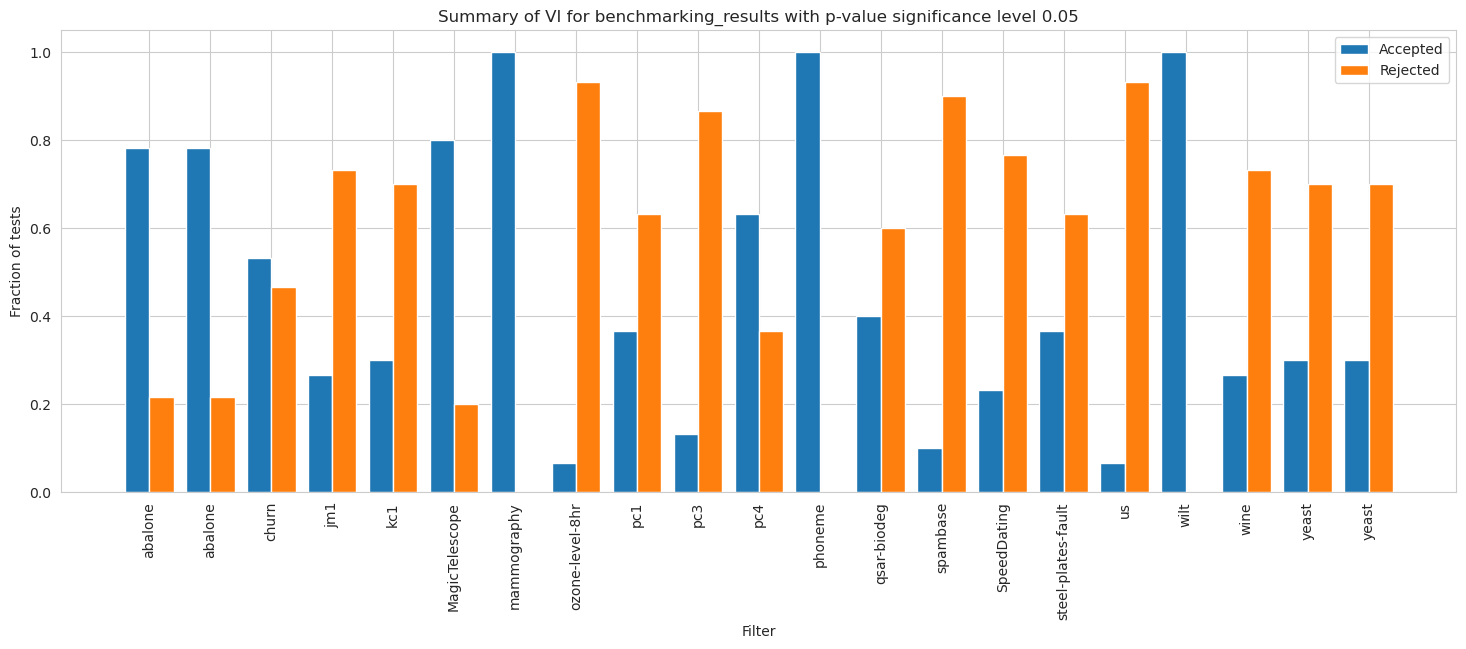

In [70]:
vi_merged_unweighted_summary_results = vi_unweighted.plot_summary(model_filters=dataset_names, figsize=(18, 6), significance_level=0.05, return_df=True)
plt.xticks(rotation=90)
plt.show()

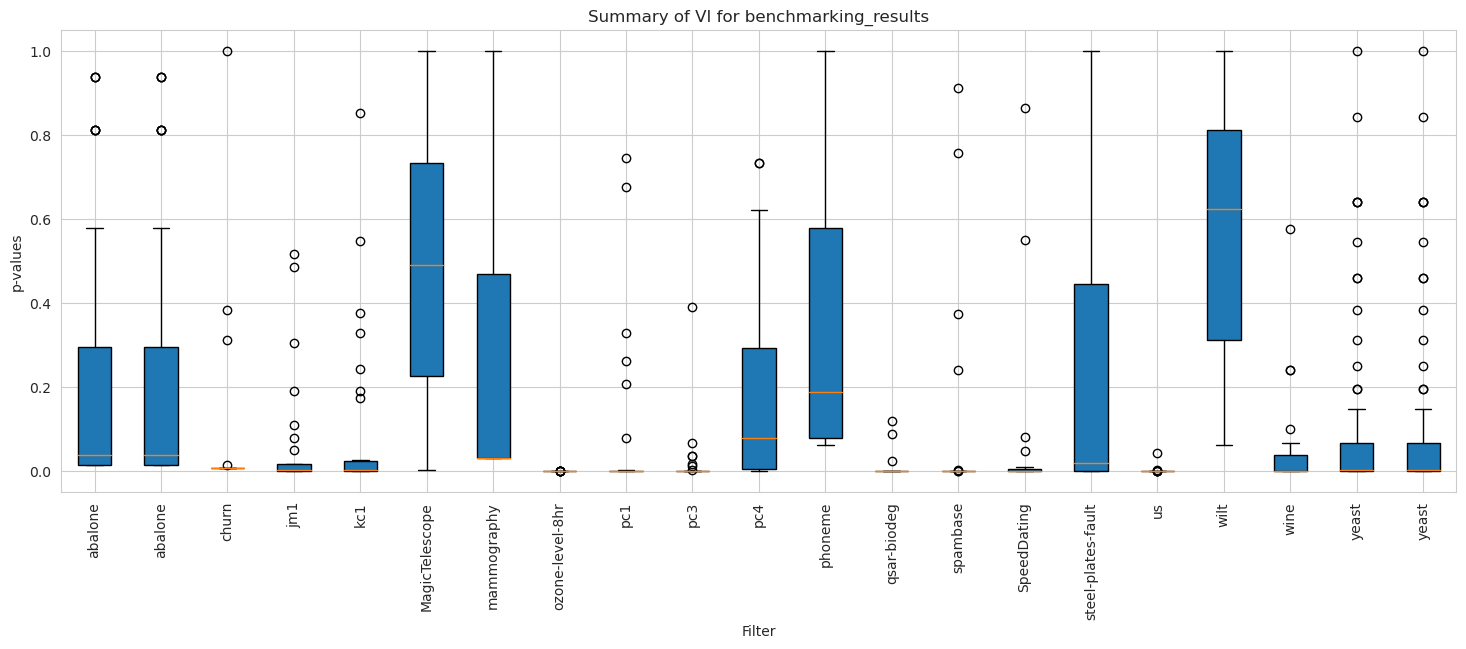

In [71]:
vi_weighted.plot_summary(model_filters=dataset_names, figsize=(18, 6))
plt.xticks(rotation=90)
plt.show()

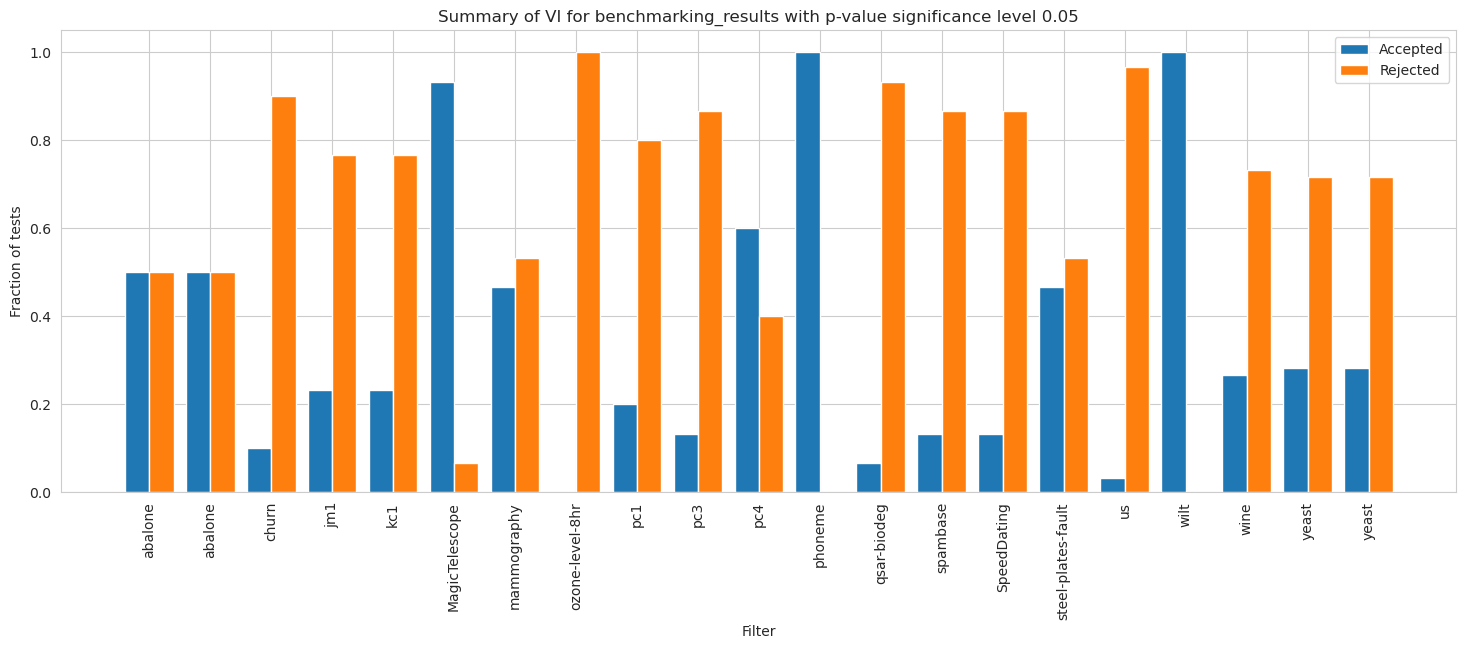

In [73]:
vi_merged_weighted_summary_results = vi_weighted.plot_summary(model_filters=dataset_names, figsize=(18, 6), significance_level=0.05, return_df=True)
plt.xticks(rotation=90)
plt.show()

In [74]:
vi_merged_weighted_summary_results_accepted = [extract_accepted_rejected(q, 0.05) for q in vi_merged_weighted_summary_results]
vi_merged_unweighted_summary_results_accepted = [extract_accepted_rejected(q, 0.05) for q in vi_merged_unweighted_summary_results]

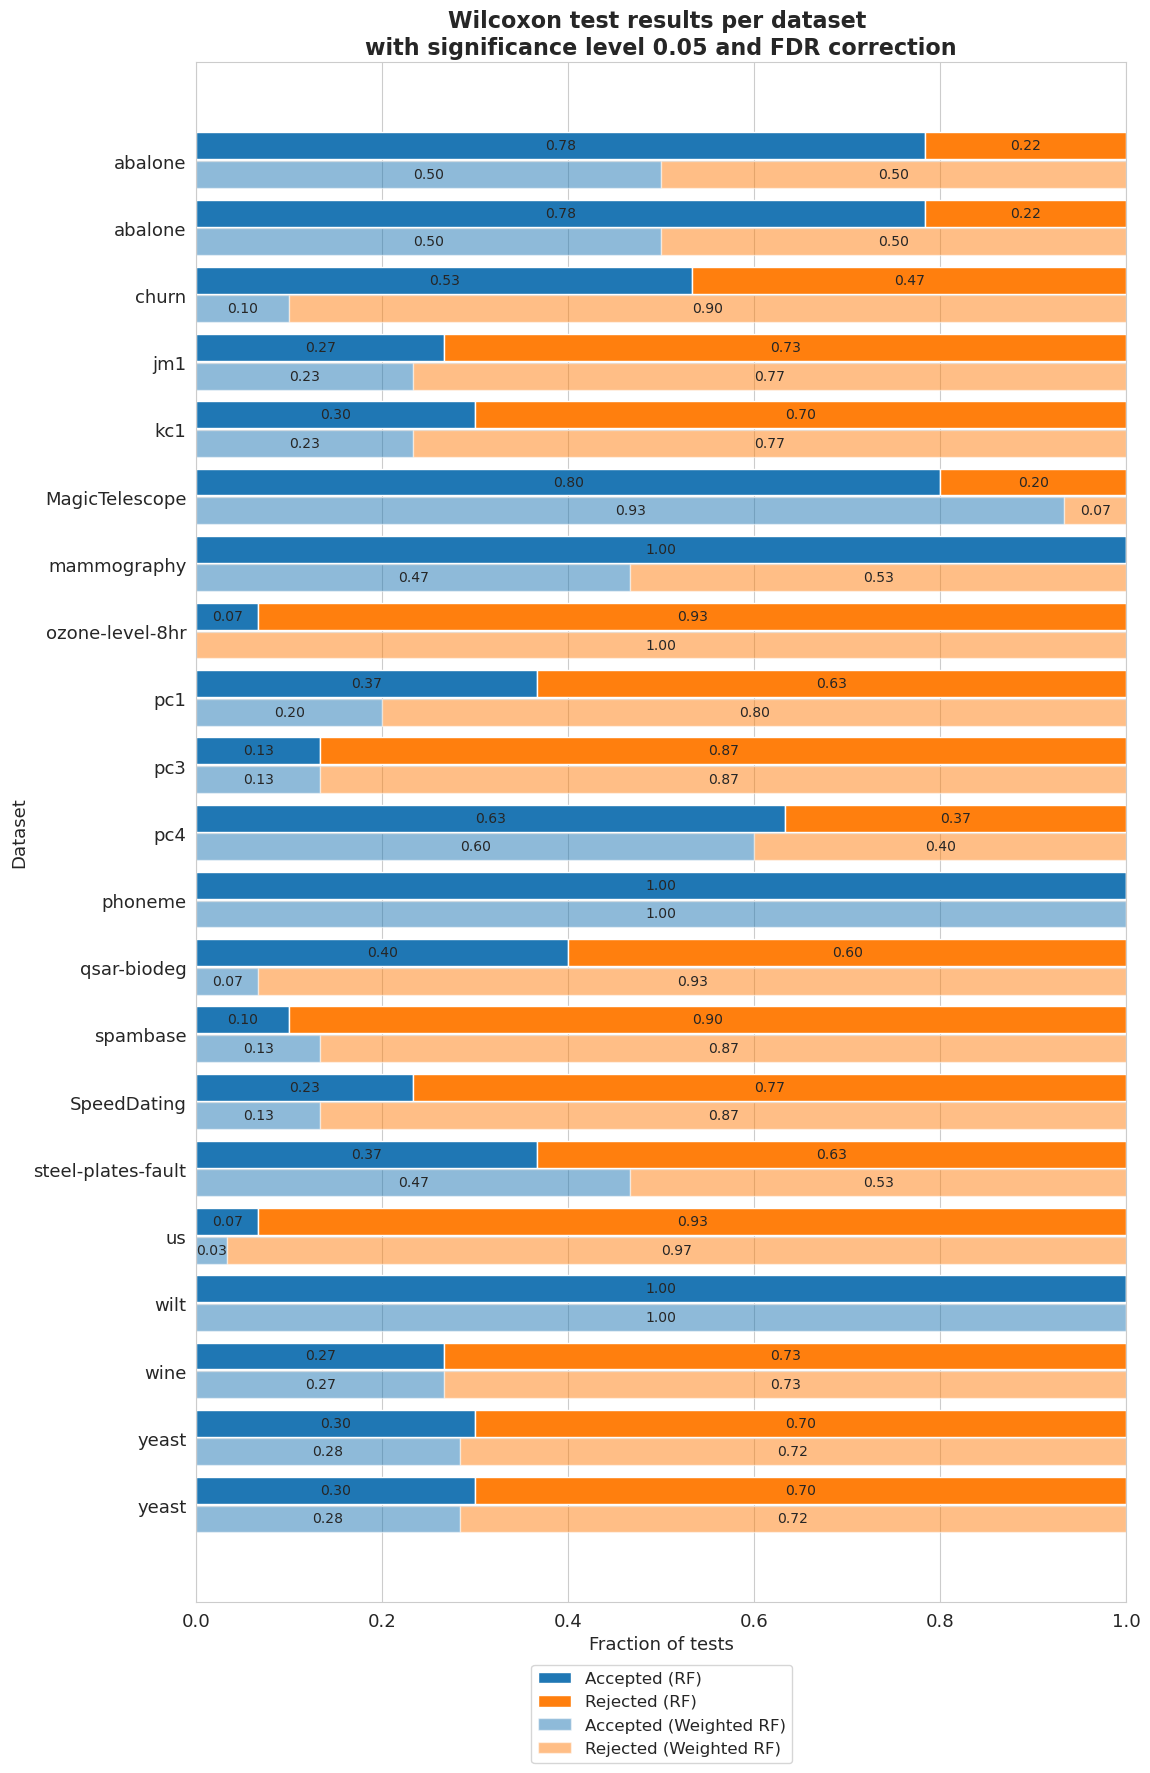

In [77]:
plt.figure(figsize=(12, 20))

height = 0.4

r = np.arange(len(dataset_names)) - height/2 - 0.025
bottom = [q[0] for q in vi_merged_unweighted_summary_results_accepted]
top = [q[1] for q in vi_merged_unweighted_summary_results_accepted]
bar1 = plt.barh(r, bottom, height=height, label='Accepted (RF)', color='#1f77b4')
bar2 = plt.barh(r, top, left=bottom, height=height, label='Rejected (RF)', color='#ff7f0e')

r = r + height + 0.025
bottom = [q[0] for q in vi_merged_weighted_summary_results_accepted]
top = [q[1] for q in vi_merged_weighted_summary_results_accepted]
bar3 = plt.barh(r, bottom, height=height, label='Accepted (Weighted RF)', color='#1f77b4', alpha=0.5)
bar4 = plt.barh(r, top, left=bottom, height=height, label='Rejected (Weighted RF)', color='#ff7f0e', alpha=0.5)

plt.yticks(np.arange(len(dataset_names)), dataset_names)
plt.gca().invert_yaxis()

lgd = plt.legend(bbox_to_anchor=(0.65, -0.035), fontsize=12)
plt.title('Wilcoxon test results per dataset \nwith significance level 0.05 and FDR correction', fontsize=16, weight='bold')
plt.xlabel('Fraction of tests', fontsize=13)
plt.ylabel('Dataset', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax = plt.gca()
ax.bar_label(bar1, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar1], label_type='center', fontsize=10)
ax.bar_label(bar2, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar2], label_type='center', fontsize=10)
ax.bar_label(bar3, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar3], label_type='center', fontsize=10)
ax.bar_label(bar4, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar4], label_type='center', fontsize=10)

plt.show()

#### Balancedness

In [80]:
balancedness = ['=0.8IR_RANGE', '=0.6IR_RANGE', '=0.4IR_RANGE', '=0.2IR_RANGE', '=0.0IR_RANGE']
vals = ['0.8', '0.6', '0.4', '0.2', '0.0']

/home/adrian/anaconda3/envs/EDGAR/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


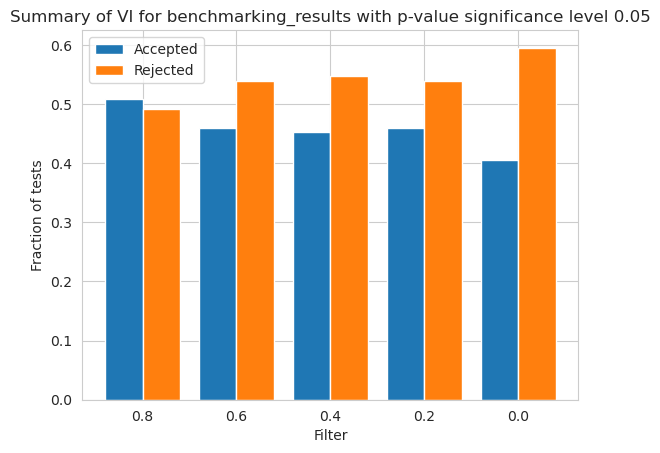

In [81]:
vi_merged_unweighted_summary_results = vi_unweighted.plot_summary(balancedness, vals, significance_level=0.05, return_df=True)
plt.show()

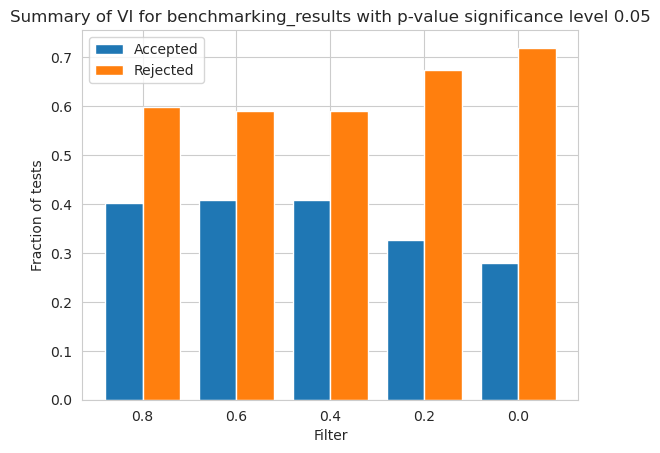

In [82]:
vi_merged_weighted_summary_results = vi_weighted.plot_summary(balancedness, vals, significance_level=0.05, return_df=True)
plt.show()

In [83]:
vi_merged_weighted_summary_results_accepted = [extract_accepted_rejected(q, 0.05) for q in vi_merged_weighted_summary_results]
vi_merged_unweighted_summary_results_accepted = [extract_accepted_rejected(q, 0.05) for q in vi_merged_unweighted_summary_results]

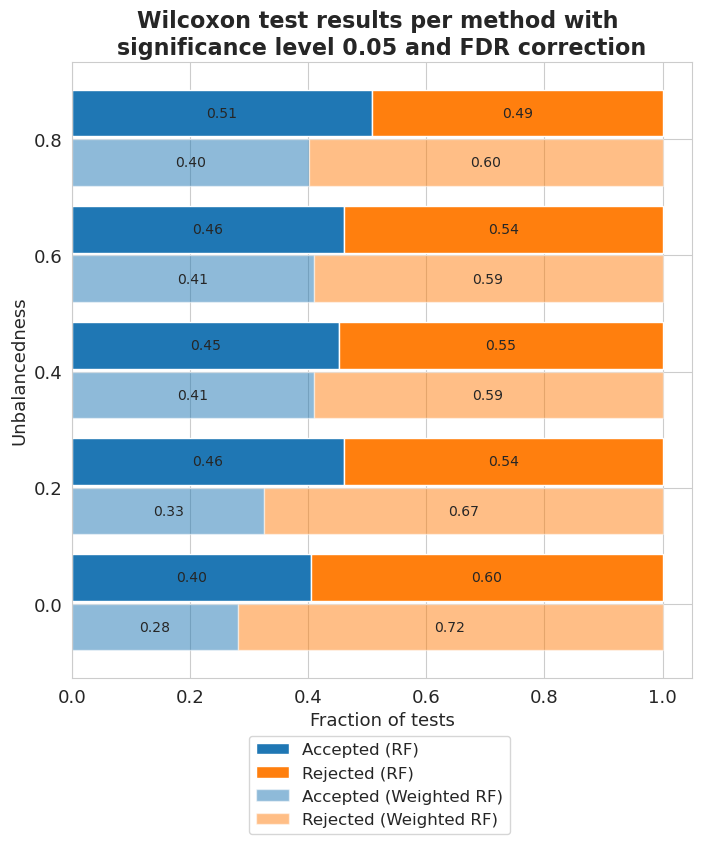

In [84]:
plt.figure(figsize=(8, 8))

height = 0.4

r = np.arange(len(vals)) - height/2 - 0.025
bottom = [q[0] for q in vi_merged_unweighted_summary_results_accepted]
top = [q[1] for q in vi_merged_unweighted_summary_results_accepted]
bar1 = plt.barh(r, bottom, height=height, label='Accepted (RF)', color='#1f77b4')
bar2 = plt.barh(r, top, left=bottom, height=height, label='Rejected (RF)', color='#ff7f0e')

r = r + height + 0.025
bottom = [q[0] for q in vi_merged_weighted_summary_results_accepted]
top = [q[1] for q in vi_merged_weighted_summary_results_accepted]
bar3 = plt.barh(r, bottom, height=height, label='Accepted (Weighted RF)', color='#1f77b4', alpha=0.5)
bar4 = plt.barh(r, top, left=bottom, height=height, label='Rejected (Weighted RF)', color='#ff7f0e', alpha=0.5)
plt.yticks(np.arange(len(vals)), vals)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(0.72, -0.08), fontsize=12)
plt.title('Wilcoxon test results per method with \nsignificance level 0.05 and FDR correction', fontsize=16, weight='bold')
plt.xlabel('Fraction of tests', fontsize=13)
plt.ylabel('Unbalancedness', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax = plt.gca()
ax.bar_label(bar1, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar1], label_type='center', fontsize=10)
ax.bar_label(bar2, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar2], label_type='center', fontsize=10)
ax.bar_label(bar3, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar3], label_type='center', fontsize=10)
ax.bar_label(bar4, labels = [f'{b.get_width():.2f}' if b.get_width() != 0 else '' for b in bar4], label_type='center', fontsize=10)

plt.show()

#### `wilt` dataset

In [85]:
names2 = [
    'Original data',
    'Random Undersampling',
    'Random Oversampling', 
    'SMOTE (oversampling)', 
    'Near Miss (undersampling)', 
    'Borderline SMOTE (oversampling)', 
    'SMOTETomek (hybrid)'
]

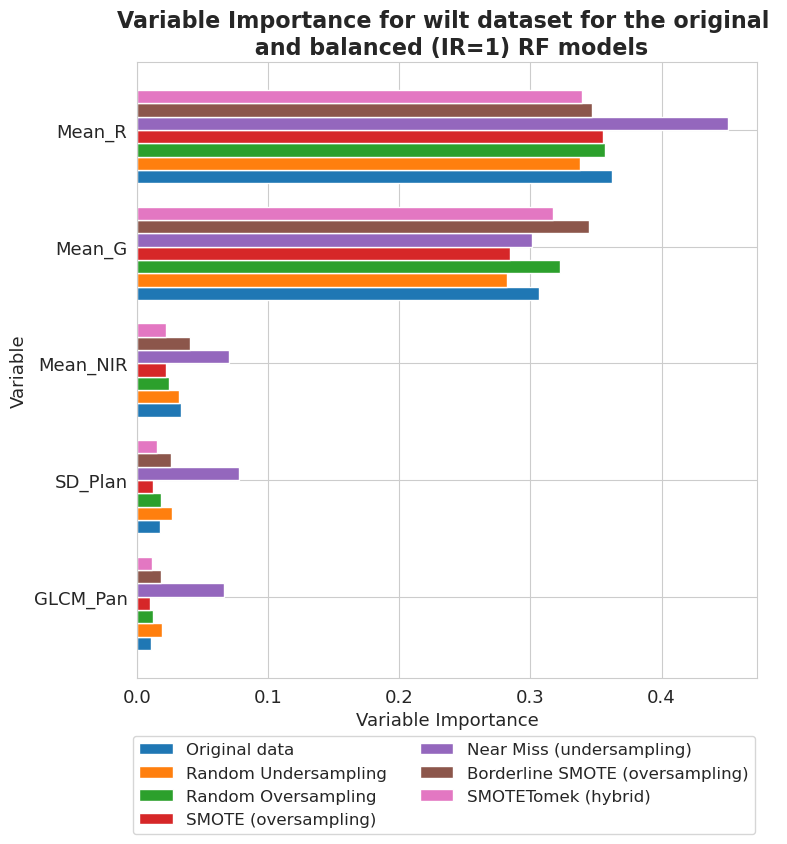

In [86]:
fig, ax = plt.subplots(figsize=(8, 8))
vi_unweighted[-4][-1].plot(show_legend=True, ax=ax, 
                           add_plot=[vi_unweighted[-4][k][-1] for k in range(len(vi_unweighted[-4])-1)])
ax.texts = []
lgd = plt.legend(names2, ncol=len(names2)//3, bbox_to_anchor=(1.01, -0.08), fontsize=12)
plt.title('Variable Importance for wilt dataset for the original \n and balanced (IR=1) RF models', fontsize=16, weight='bold')
plt.xlabel('Variable Importance', fontsize=13)
plt.ylabel('Variable', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

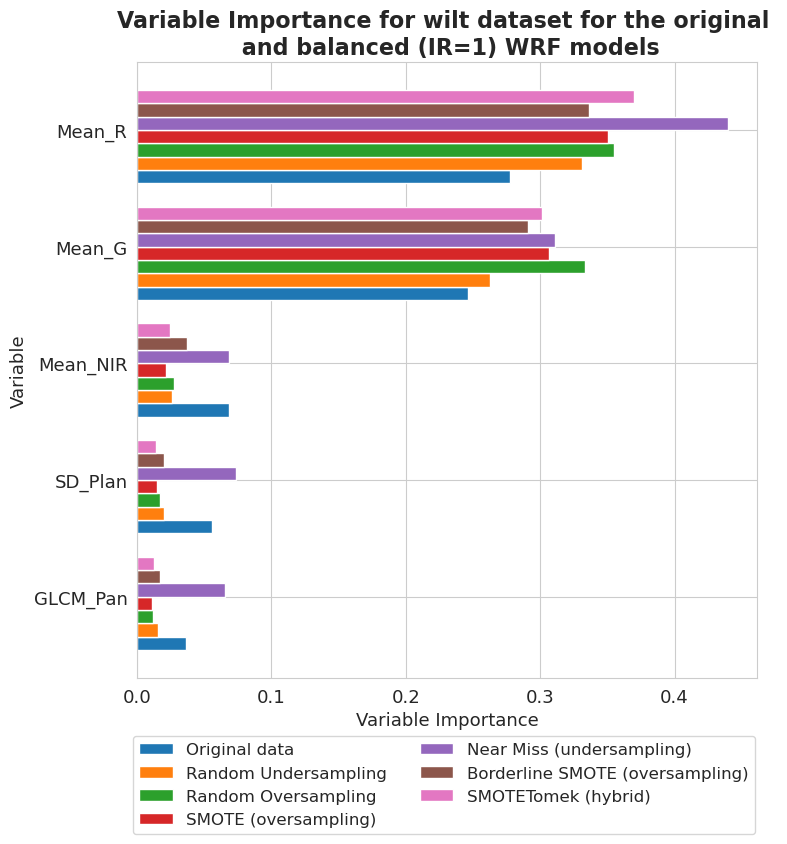

In [87]:
fig, ax = plt.subplots(figsize=(8, 8))
vi_weighted[-4][-1].plot(show_legend=True, ax=ax, 
                         add_plot=[vi_weighted[-4][k][-1] for k in range(len(vi_weighted[-4])-1)])
ax.texts = []
lgd = plt.legend(names2, ncol=len(names2)//3, bbox_to_anchor=(1.01, -0.08), fontsize=12)
plt.title('Variable Importance for wilt dataset for the original \n and balanced (IR=1) WRF models', fontsize=16, weight='bold')
plt.xlabel('Variable Importance', fontsize=13)
plt.ylabel('Variable', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

#### `qsar-biodeg` dataset

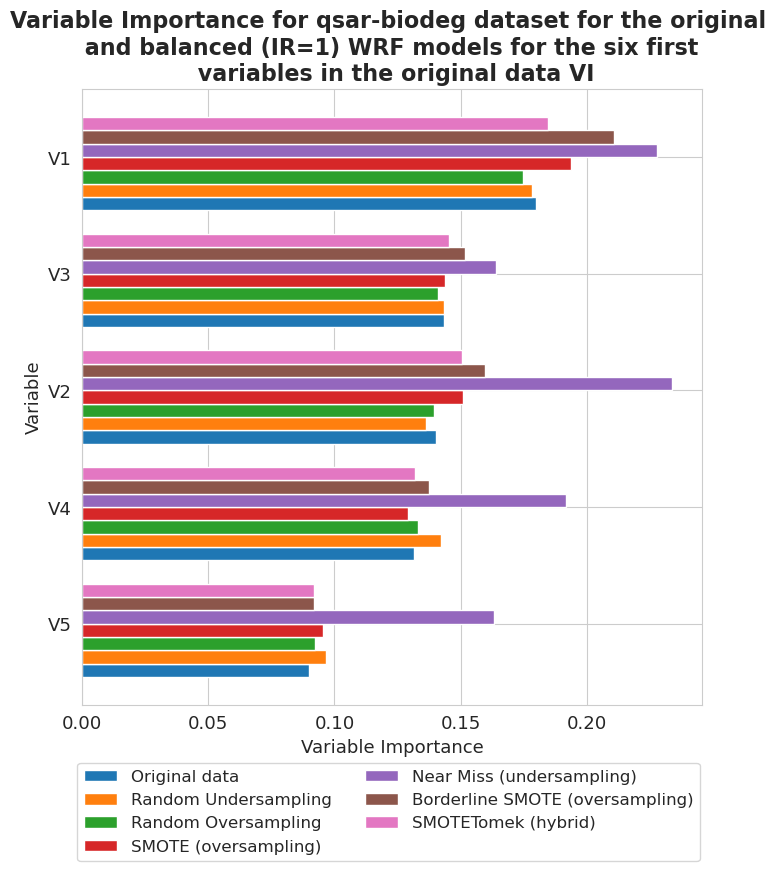

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))
vi_weighted[12][-1].plot(show_legend=True, ax=ax, 
                         add_plot=[vi_weighted[12][k][-1] for k in range(len(vi_weighted[12])-1)], max_variables=6)
ax.texts = []
plt.title('Variable Importance for qsar-biodeg dataset for the original \n and balanced (IR=1) WRF models for the six first \n variables in the original data VI', 
          fontsize=16, weight='bold')
plt.legend(names2, ncol=len(names2)//3, bbox_to_anchor=(1.01, -0.08), fontsize=12)
plt.xlabel('Variable Importance', fontsize=13)
plt.ylabel('Variable', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

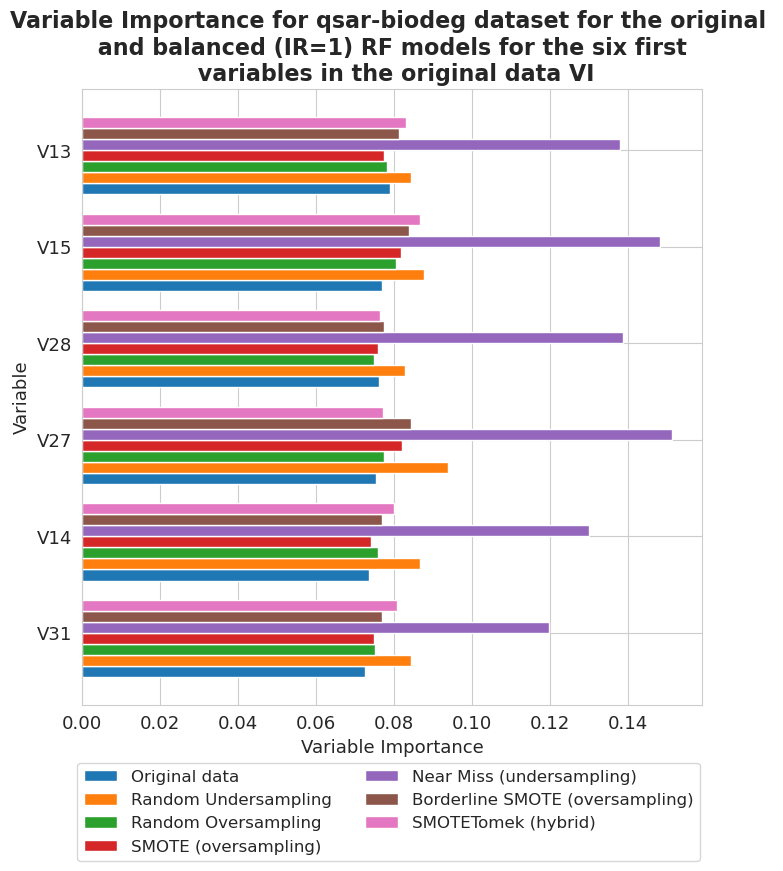

In [89]:
fig, ax = plt.subplots(figsize=(8, 8))
vi_unweighted[12][-1].plot(show_legend=True, ax=ax, 
                           add_plot=[vi_unweighted[12][k][-1] for k in range(len(vi_unweighted[12])-1)], max_variables=6)
ax.texts = []
plt.title('Variable Importance for qsar-biodeg dataset for the original \n and balanced (IR=1) RF models for the six first \n variables in the original data VI', 
          fontsize=16, weight='bold')
plt.legend(names2, ncol=len(names2)//3, bbox_to_anchor=(1.01, -0.08), fontsize=12)
plt.xlabel('Variable Importance', fontsize=13)
plt.ylabel('Variable', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()